# FX trading signals and regression-based learning

This notebook illustrates the points discussed in the post "FX trading signals and regression-based learning" on the Macrosynergy website. It demonstrates how regression-based statistical learning helps build trading signals from multiple candidate constituents. The method optimizes models and hyperparameters sequentially and produces point-in-time signals for backtesting and live trading. This post applies regression-based learning to a selection of macro trading factors for developed market FX trading, using a novel cross-validation method for expanding panel data. Sequentially optimized models consider nine theoretically valid macro trend indicators to predict FX forward returns. The learning process has delivered significant predictors of returns and consistent positive PnL generation for over 20 years. The most important macro-FX signals, in the long run, have been relative labor market trends, manufacturing business sentiment changes, inflation expectations, and terms of trade dynamics.

The notebook is organized into three main sections:

- __Get Packages and JPMaQS Data:__ This section is dedicated to installing and importing the necessary Python packages for the analysis. It includes standard Python libraries like pandas and seaborn, as well as the [`scikit-learn`](https://scikit-learn.org/stable/) package and the specialized [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package.

- __Transformations and Checks:__ In this part, the notebook conducts data calculations and transformations to derive relevant signals and targets for the analysis. This involves constructing simple linear composite indicators, means, relative values, etc.

- __Actual regression-based learning:__, employing the learning module of [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package for LinearRegression() from [`scikit-learn`](https://scikit-learn.org/stable/) package defining hyperparameter grid, employed models, cross-validation splits, optimization criteria, etc. 

- __Value checks__ and comparison of conceptual parity signal with OLS based learning signals. The comparison is performed using standard performance metrics, as well as calculating naive PnLs (Profit and Loss) for simple relative trading strategies based on both risk parity and OLS based learning signals.

- __Alternative models of regression-based learning__ explores additional models: Regularized linear model (elastic net), Sign-weighted linear regression, Time-weighted linear regression - using the standard performance metrics with naive PnL calculations.



## Get packages and JPMaQS data

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet

from sklearn.metrics import (
    make_scorer,
    r2_score,
)

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.pnl as msn
import macrosynergy.signal as mss
import macrosynergy.learning as msl
import macrosynergy.visuals as msv

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

In [2]:
# Cross-sections of interest - FX
cids_g3 = ["EUR", "JPY", "USD"]  # DM large currency areas
cids_dmfx = ["AUD", "CAD", "CHF", "GBP", "NOK", "NZD", "SEK"]  # DM small currency areas

cids_dm = cids_g3 + cids_dmfx
cids = cids_dm

cids_eur = ["CHF", "NOK", "SEK"]  # trading against EUR
cids_eud = ["GBP"]  # trading against EUR and USD
cids_usd = list(set(cids_dmfx) - set(cids_eur + cids_eud))  # trading against USD

In [3]:
# Quantamental features of interest

ir = [
    "RIR_NSA",
]

ctots = [
    "CTOT_NSA_P1M1ML12",
    "CTOT_NSA_P1M12ML1",
    "CTOT_NSA_P1W4WL1",
]

surv = [
    "MBCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA_D1Q1QL1",
    "MBCSCORE_SA_D6M6ML6",
    "MBCSCORE_SA_D2Q2QL2",
]

ppi = [
    "PGDPTECH_SA_P1M1ML12_3MMA",
]

gdps = [
    "INTRGDP_NSA_P1M1ML12_3MMA",
]

emp = [
    "UNEMPLRATE_SA_D3M3ML3",
    "UNEMPLRATE_SA_D6M6ML6",
    "UNEMPLRATE_SA_D1Q1QL1",
    "UNEMPLRATE_SA_D2Q2QL2",
    "UNEMPLRATE_NSA_3MMA_D1M1ML12",
    "UNEMPLRATE_NSA_D1Q1QL4",
]

iip = [
    "IIPLIABGDP_NSA",
]

cpi = [
    "CPIXFE_SA_P1M1ML12",
    "CPIXFE_SJA_P3M3ML3AR",
    "CPIXFE_SJA_P6M6ML6AR",
    "INFE1Y_JA",
    "INFE2Y_JA",
    "INFE5Y_JA",
]

tots = ctots

main = tots + gdps + surv + ir + emp + iip + ppi + cpi

adds = [
    "INFTEFF_NSA",
]

mkts = [
    "FXTARGETED_NSA",
    "FXUNTRADABLE_NSA",
]

rets = [
    "FXXR_VT10",
]

xcats = main + mkts + rets + adds

# Resultant tickers for download

single_tix = ["USD_GB10YXR_NSA", "EUR_FXXR_NSA", "USD_EQXR_NSA"]
tickers = [cid + "_" + xcat for cid in cids for xcat in xcats] + single_tix

JPMaQS indicators are conveniently grouped into six main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available under the [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/). For tickers used in this notebook see [Real short-term interest rates](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Real%20interest%20rates.php), [Terms-of-trade](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Terms-of-trade.php), [Manufacturing confidence scores](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Manufacturing%20confidence%20scores.php), [Producer price inflation](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Producer%20price%20inflation.php), [Intuitive GDP growth estimates](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Intuitive%20GDP%20growth%20estimates.php), [Labor market dynamics](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Labor%20market%20dynamics.php), [International investment position](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/International%20investment%20position.php), [Consistent core CPI trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Consistent%20core%20CPI%20trends.php), [FX forward returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/FX%20forward%20returns.php), and [FX tradeability and flexibility](https://academy.macrosynergy.com/academy/Themes/Stylized%20trading%20factors/_build/html/notebooks/FX%20tradeability%20and%20flexibility.php). 
JPMaQS indicators are conveniently grouped into six main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/). For tickers used in this notebook see [Real short-term interest rates](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Real%20interest%20rates.php), [Terms-of-trade](https://academy.macrosynergy.com/academy/Themes/Financial%20conditions/_build/html/notebooks/Terms-of-trade.php), [Manufacturing confidence scores](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Manufacturing%20confidence%20scores.php), [Producer price inflation](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Producer%20price%20inflation.php), [Intuitive GDP growth estimates](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Intuitive%20GDP%20growth%20estimates.php), [Labor market dynamics](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Labor%20market%20dynamics.php), [International investment position](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/International%20investment%20position.php), [Consistent core CPI trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Consistent%20core%20CPI%20trends.php), [Inflation expectations](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20expectations.php), [Inflation targets](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20targets.php), [FX forward returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/FX%20forward%20returns.php), and [FX tradeability and flexibility](https://academy.macrosynergy.com/academy/Themes/Stylized%20trading%20factors/_build/html/notebooks/FX%20tradeability%20and%20flexibility.php). 


In this notebook, we introduce several lists of currencies for the sake of convenience in our subsequent analysis:

- `cids_g3` represents the 3 largest developed market currencies.
- `cids_dmfx` represents DM small currency areas.
- `cids_eur` trading against EUR.
- `cids_eud` trading against EUR and USD
- `cids_usd` trading against USD

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md)

In [4]:
# Download series from J.P. Morgan DataQuery by tickers

start_date = "1990-01-01"
end_date = None

# Retrieve credentials

client_id = os.getenv("DQ_CLIENT_ID")  # Replace with own client ID
client_secret = os.getenv("DQ_CLIENT_SECRET")  # Replace with own secret
proxy = {
    # "https": "https://example.com:port",
}

# Download from DataQuery

downloader = JPMaQSDownload(client_id=client_id, client_secret=client_secret, proxy=proxy)
df = downloader.download(
    tickers=tickers,
    start_date=start_date,
    end_date=end_date,
    metrics=["value"],
    suppress_warning=True,
    show_progress=True,
)

dfx = df.copy()
dfx.info()

Timestamp UTC:  2024-12-03 16:20:54
Connection successful!


Requesting data: 100%|█████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.71it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
53 out of 273 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 9114 dates are missing.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649099 entries, 0 to 1649098
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   real_date  1649099 non-null  datetime64[ns]
 1   cid        1649099 non-null  object        
 2   xcat       1649099 non-null  object        
 3   value      1649099 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 50.3+ MB


## Availability and blacklisting

### Renaming

Rename quarterly tickers to roughly equivalent monthly tickers to simplify subsequent operations.

In [5]:
dict_repl = {
    "UNEMPLRATE_NSA_D1Q1QL4": "UNEMPLRATE_NSA_3MMA_D1M1ML12",
    "UNEMPLRATE_SA_D1Q1QL1": "UNEMPLRATE_SA_D3M3ML3",
    "UNEMPLRATE_SA_D2Q2QL2": "UNEMPLRATE_SA_D6M6ML6",
    "MBCSCORE_SA_D1Q1QL1": "MBCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA_D2Q2QL2": "MBCSCORE_SA_D6M6ML6",
}

for key, value in dict_repl.items():
    dfx["xcat"] = dfx["xcat"].str.replace(key, value)

### Check availability

Prior to commencing any analysis, it is crucial to evaluate the accessibility of data. This evaluation serves several purposes, including identifying potential data gaps or constraints within the dataset. Such gaps can significantly influence the trustworthiness and accuracy of the analysis. Moreover, it aids in verifying that ample observations are accessible for each chosen category and cross-section. Additionally, it assists in establishing suitable timeframes for conducting the analysis.

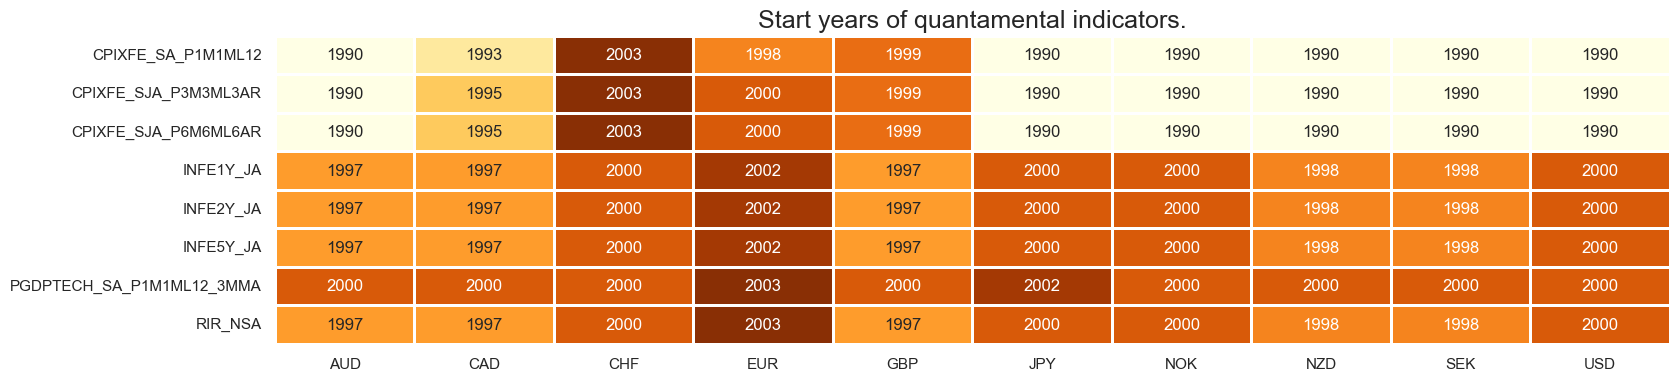

In [6]:
xcatx = cpi + ppi + ir
msm.check_availability(df=dfx, xcats=xcatx, cids=cids, missing_recent=False)

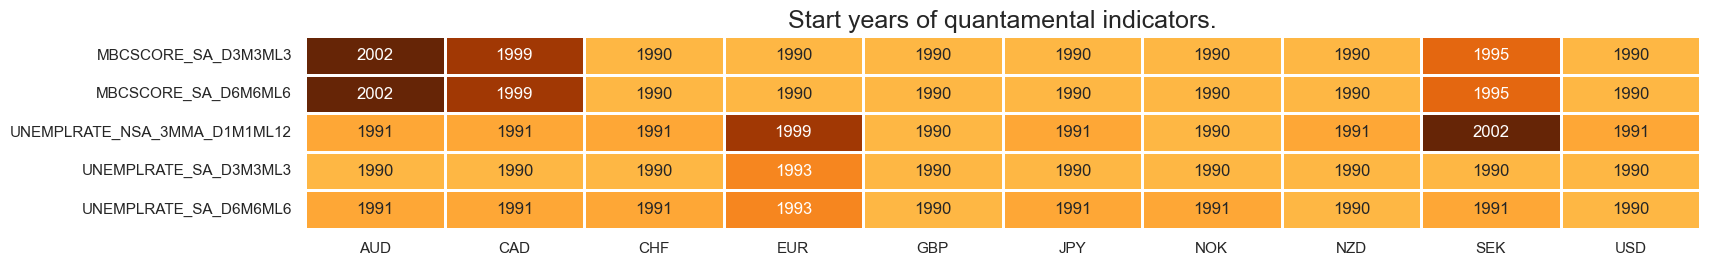

In [7]:
xcatx = surv + emp
msm.check_availability(df=dfx, xcats=xcatx, cids=cids, missing_recent=False)

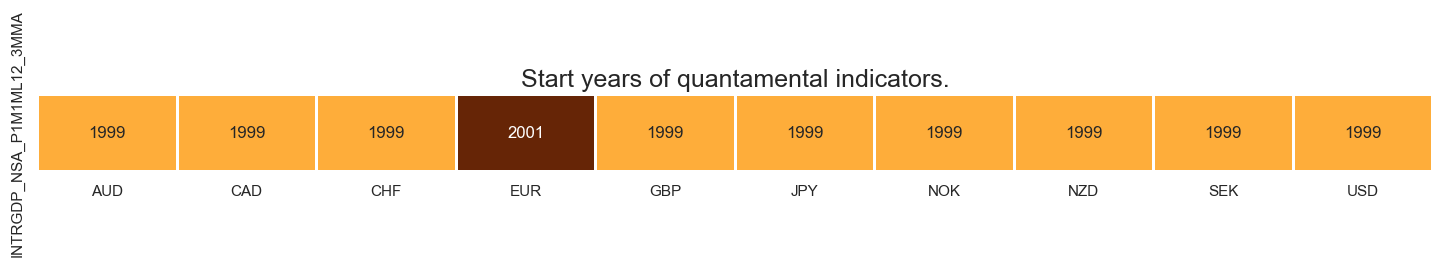

In [8]:
xcatx = gdps
msm.check_availability(df=dfx, xcats=xcatx, cids=cids, missing_recent=False)

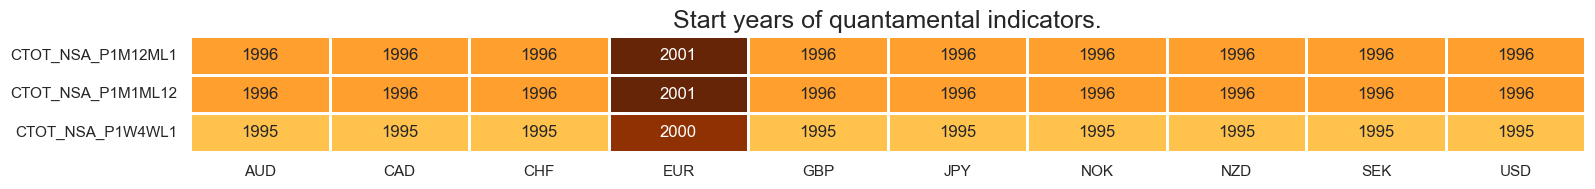

In [9]:
xcatx = ctots
msm.check_availability(df=dfx, xcats=xcatx, cids=cids, missing_recent=False)

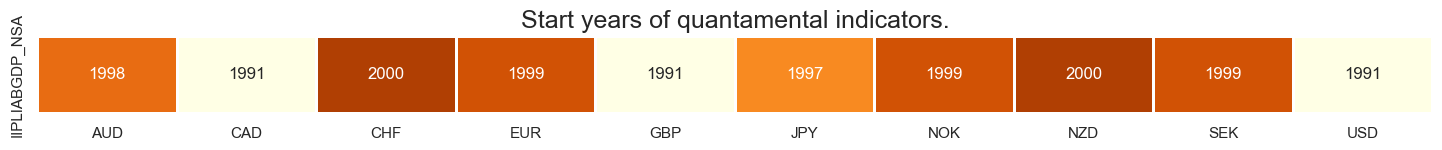

In [10]:
xcatx = iip
msm.check_availability(df=dfx, xcats=xcatx, cids=cids, missing_recent=False)

### Blacklisting

Identifying and isolating periods of official exchange rate targets, illiquidity, or convertibility-related distortions in FX markets is the first step in creating an FX trading strategy. These periods can significantly impact the behavior and dynamics of currency markets, and failing to account for them can lead to inaccurate or misleading findings. A standard blacklist dictionary (`fxblack` in the cell below) can be passed to several [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package functions that exclude the blacklisted periods from related analyses. 

In [11]:
# Create blacklisting dictionary

dfb = df[df["xcat"].isin(["FXTARGETED_NSA", "FXUNTRADABLE_NSA"])].loc[
    :, ["cid", "xcat", "real_date", "value"]
]
dfba = (
    dfb.groupby(["cid", "real_date"])
    .aggregate(value=pd.NamedAgg(column="value", aggfunc="max"))
    .reset_index()
)
dfba["xcat"] = "FXBLACK"
fxblack = msp.make_blacklist(dfba, "FXBLACK")
fxblack

{'CHF': (Timestamp('2011-10-03 00:00:00'), Timestamp('2015-01-30 00:00:00'))}

## Transformations and checks

### Single-concept calculations

#### Unemployment rate changes

The [`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is used to combine individual category scores into a single composite indicator. This technique allows for the assignment of specific weights to each category, which can be adjusted over time according to analysis needs or data insights. In this example, the weights [4, 2, 1] are allocated to three different measures of unemployment trends: "UNEMPLRATE_SA_D3M3ML3", "UNEMPLRATE_SA_D6M6ML6", and "UNEMPLRATE_NSA_3MMA_D1M1ML12". By applying these weights, a unified composite indicator, named `UNEMPLRATE_SA_D`, is created, offering a weighted perspective on unemployment trends.

In [12]:
# Combine to annualized change average
xcatx = [
    "UNEMPLRATE_SA_D3M3ML3",
    "UNEMPLRATE_SA_D6M6ML6",
    "UNEMPLRATE_NSA_3MMA_D1M1ML12",
]
cidx = cids_dm

dfa = msp.linear_composite(
    dfx,
    xcats=xcatx,
    cids=cidx,
    weights=[4, 2, 1],
    normalize_weights=True,
    complete_xcats=False,
    new_xcat="UNEMPLRATE_SA_D",
)

dfx = msm.update_df(dfx, dfa)

#### International liabilities trends


To analyze trends in the information states of liabilities compared to the past 2 and 5 years, the process begins by computing 2-Year and 5-Year rolling averages. These averages are then subtracted from the current trend to highlight deviations or changes over the specified periods. Utilizing the  [`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the  [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package, these calculated deviations for each time frame are combined into a single composite indicator named `IIPLIABGDP_NSA_D`. In this aggregation, greater importance is assigned to the 2-Year trend compared to the 5-Year trend, as reflected by the allocation of higher weights to the former in the weighting scheme used within the function. 

In [13]:
# Two plausible information state trends

cidx = cids_dm
calcs = [
    " IIPLIABGDP_NSA_2YAVG = IIPLIABGDP_NSA.rolling(21*24).mean() ",
    " IIPLIABGDP_NSA_5YAVG = IIPLIABGDP_NSA.rolling(21*60).mean() ",
    " IIPLIABGDP_NSAv2YAVG = IIPLIABGDP_NSA - IIPLIABGDP_NSA_2YAVG ",
    " IIPLIABGDP_NSAv5YAVG = IIPLIABGDP_NSA - IIPLIABGDP_NSA_5YAVG ",
]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

In [14]:
# Combine to single trend measure

cidx = cids_dm
xcatx = [
    "IIPLIABGDP_NSAv2YAVG",
    "IIPLIABGDP_NSAv5YAVG",
]

dfa = msp.linear_composite(
    dfx,
    xcats=xcatx,
    cids=cidx,
    weights=[1/2, 1/5],
    normalize_weights=True,
    complete_xcats=False,
    new_xcat="IIPLIABGDP_NSA_D",
)

dfx = msm.update_df(dfx, dfa)

#### Excess producer and core consumer price inflation

[`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is utilized to synthesize individual inflation trends scores into a consolidated composite indicator, applying equal weights to each score. This approach ensures that all identified inflation trends contribute equally to the formation of the composite indicator, facilitating a balanced and comprehensive overview of inflationary movements.



In [15]:
cidx = cids_dm
xcatx = ['CPIXFE_SA_P1M1ML12', 'CPIXFE_SJA_P3M3ML3AR', 'CPIXFE_SJA_P6M6ML6AR']

dfa = msp.linear_composite(
    dfx,
    xcats=xcatx,
    cids=cidx,
    complete_xcats=False,
    new_xcat="CPIXFE_SA_PAR",
)

dfx = msm.update_df(dfx, dfa)


In this analysis, the difference is calculated between the estimated inflation expectations for the local economy, represented by the average labeled `CPIXFE_SA_PAR`, and the inflation expectations for the benchmark currency area, denoted by `INFTEFF_NSA`. This calculation produces a new indicator named `XCPIXFE_SA_PAR`, which reflects the deviation of local inflation expectations from those of the benchmark currency area.

Similarly, for the Producer Price Inflation trend, the same method is applied. The difference between the local Producer Price Inflation trend and the benchmark currency area's trend is calculated. This results in the creation of a new indicator, which is labeled `XPGDPTECH_SA_P1M1ML12_3MMA`. This new indicator captures the disparity in the Producer Price Inflation trend between the local economy and the benchmark currency area, providing insights into relative inflationary pressures from the perspective of producers.


In [16]:
cidx = cids_dm
xcatx = ["CPIXFE_SA_PAR", "PGDPTECH_SA_P1M1ML12_3MMA"]
calcs = []

for xc in xcatx:
    calcs.append(f" X{xc} = {xc} - INFTEFF_NSA ")   

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

#### Inflation expectations

The [`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is used to compute the average of 1-year, 2-year, and 5-year inflation expectations, culminating in the creation of a composite indicator named `INFE_JA`. This method effectively consolidates the various inflation expectation horizons into a single, comprehensive measure, providing a more holistic view of expected inflation trends over multiple time frames.

In [17]:
cidx = cids_dm
xcatx = ['INFE1Y_JA', 'INFE2Y_JA', 'INFE5Y_JA']

dfa = msp.linear_composite(
    dfx,
    xcats=xcatx,
    cids=cidx,
    complete_xcats=False,
    new_xcat="INFE_JA",
)

dfx = msm.update_df(dfx, dfa)

#### Commodity-based terms of trade improvement

The [`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is utilized to develop a composite indicator of commodity-based terms of trade trends, named `CTOT_NSA_PAR`. In this process, weights are assigned to reflect the relative importance of short-term changes, specifically comparing the most recent week against the preceding four weeks. This weighting strategy emphasizes the significance of the latest movements in commodity terms of trade, allowing the composite indicator to provide insights into short-term trends and their potential impact on trade conditions.

In [18]:
cidx = cids_dm
xcatx = ["CTOT_NSA_P1M1ML12", "CTOT_NSA_P1M12ML1", "CTOT_NSA_P1W4WL1"]

dfa = msp.linear_composite(
    dfx,
    xcats=xcatx,
    cids=cidx,
    weights=[1/12, 1/6, 2],
    normalize_weights=True,
    complete_xcats=False,
    new_xcat="CTOT_NSA_PAR",
)
dfx = msm.update_df(dfx, dfa)

#### Manufacturing confidence improvement

Using the same weighting approach and function, the [`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is employed to aggregate individual category scores of manufacturing confidence into a consolidated composite indicator named `MBCSCORE_SA_D`. This process involves combining various measures of manufacturing confidence into a single indicator, with weights applied to emphasize specific aspects of the data according to predefined criteria. The creation of the `MBCSCORE_SA_D` indicator enables a comprehensive view of manufacturing confidence, streamlining the analysis of this sector's sentiment.

In [19]:
cidx = cids_dm
xcatx = ["MBCSCORE_SA_D3M3ML3", "MBCSCORE_SA_D6M6ML6"]

dfa = msp.linear_composite(
    dfx,
    xcats=xcatx,
    cids=cidx,
    weights=[2, 1],
    normalize_weights=True,
    complete_xcats=False,
    new_xcat="MBCSCORE_SA_D",
)
dfx = msm.update_df(dfx, dfa)

### Relative values, sign adjustments and normalization

The [`make_relative_value()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#compute-panels-versus-basket-with-make-relative-value) function is designed to create a dataframe that showcases relative values for a specified list of categories. In this context, "relative" refers to comparing an original value against an average from a basket of choices. By default, this basket is composed of all available cross-sections, with the relative value being derived by subtracting the average of the basket from each individual cross-section value.

For this specific application, relative values are computed against either the USD or EUR as benchmarks, contingent upon the currency in question. Currencies that are typically traded against the EUR, namely CHF, NOK, and SEK (grouped in the list `cids_eur`), are calculated in relation to the EUR. The GBP is unique in that it is considered in trading against both USD and EUR, while all other currencies for this analysis are benchmarked against the USD.

As a result of this process, the generated relative time series are appended with the postfix `_vBM`, indicating their comparison against a benchmark currency. 

In [20]:
# Calculate relative values to benchmark currency areas

xcatx = [
    "UNEMPLRATE_SA_D",
    "RIR_NSA",
    "XCPIXFE_SA_PAR",
    "XPGDPTECH_SA_P1M1ML12_3MMA",
    "INTRGDP_NSA_P1M1ML12_3MMA",
    "INFE_JA",
]

dfa_usd = msp.make_relative_value(dfx, xcatx, cids_usd, basket=["USD"], postfix="vBM")
dfa_eur = msp.make_relative_value(dfx, xcatx, cids_eur, basket=["EUR"], postfix="vBM")
dfa_eud = msp.make_relative_value(
    dfx, xcatx, cids_eud, basket=["EUR", "USD"], postfix="vBM"
)

dfa = pd.concat([dfa_eur, dfa_usd, dfa_eud])
dfx = msm.update_df(dfx, dfa)

To display and compare the values for one of the resulting `INFE_JAvBM` indicator we use [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) function from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package:


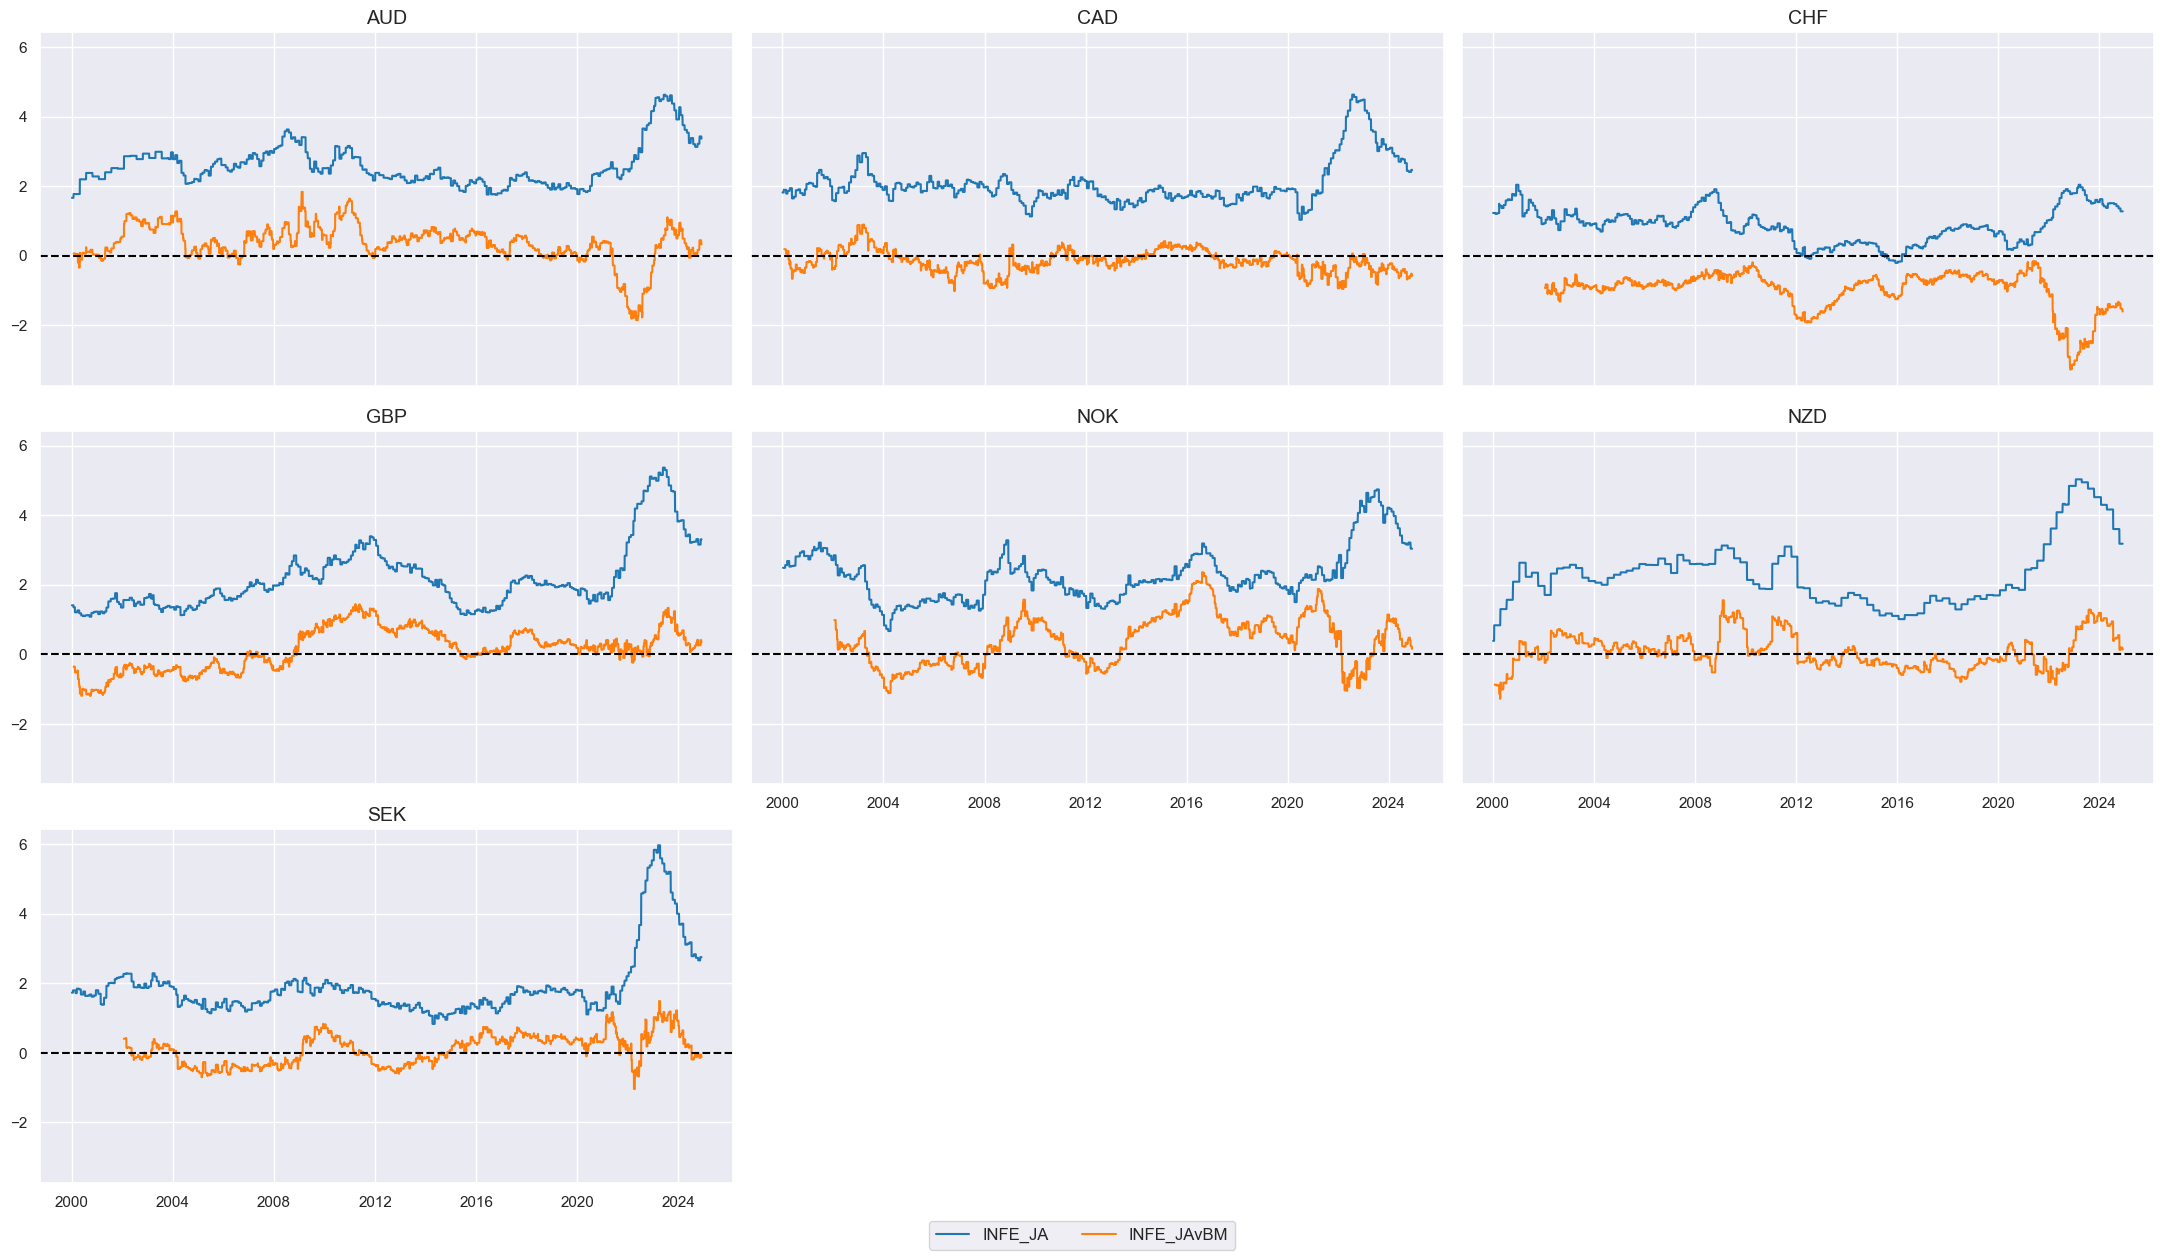

In [21]:
# Check time series
xc = "INFE_JA"

cidx = cids_dmfx
xcatx = [xc, xc + "vBM"]

msp.view_timelines(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    start="2000-01-01",
    aspect=1.7,
    ncol=3,
)

The negatives of relative unemployment rates and international liabilities to GDP series are defined. This is done for  convenience, all constituent candidates are given the “right sign” that makes their theoretically expected predictive direction positive. 


In [22]:
# Negative values

xcatx = ["UNEMPLRATE_SA_DvBM", "IIPLIABGDP_NSA_D"]
calcs = []

for xc in xcatx:
    calcs += [f"{xc}_NEG = - {xc}"]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids_dmfx)
dfx = msm.update_df(dfx, dfa)

In [23]:
# Conceptual features with theoretical positive FX impact

cpos = [
    "INFE_JAvBM",
    "CTOT_NSA_PAR",
    "UNEMPLRATE_SA_DvBM_NEG",
    "IIPLIABGDP_NSA_D_NEG",
    "RIR_NSAvBM",
    "XCPIXFE_SA_PARvBM",
    "MBCSCORE_SA_D",
    "XPGDPTECH_SA_P1M1ML12_3MMAvBM",
    "INTRGDP_NSA_P1M1ML12_3MMAvBM",
]
cpos.sort()

We normalize the plausible indicators collected in the list `cpos` above using [`make_zn_scores()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#normalize-panels-with-make-zn-scores) function. This is a standard procedure aimed at making various categories comparable, in particular, summing or averaging categories with different units and time series properties.

In [24]:
# Zn-scores

xcatx = cpos
cidx = cids_dmfx

dfa = pd.DataFrame(columns=list(dfx.columns))

for xc in xcatx:
    dfaa = msp.make_zn_scores(
        dfx,
        xcat=xc,
        cids=cidx,
        sequential=True,
        min_obs=261 * 3,
        neutral="zero",
        pan_weight=1,
        thresh=4,
        postfix="_ZN",
        est_freq="m",
    )
    dfa = msm.update_df(dfa, dfaa)

dfx = msm.update_df(dfx, dfa)
cpoz = [x + "_ZN" for x in cpos]

Renaming indicators to more intuitive names rather than technical tickers is a beneficial practice for enhancing the readability and interpretability of data analyses. 

The [`correl_matrix()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-relations-across-sections-or-categories-with-correl-matrix) function visualizes correlation coefficient between signal constituent candidates for a panel of seven DM countries since 

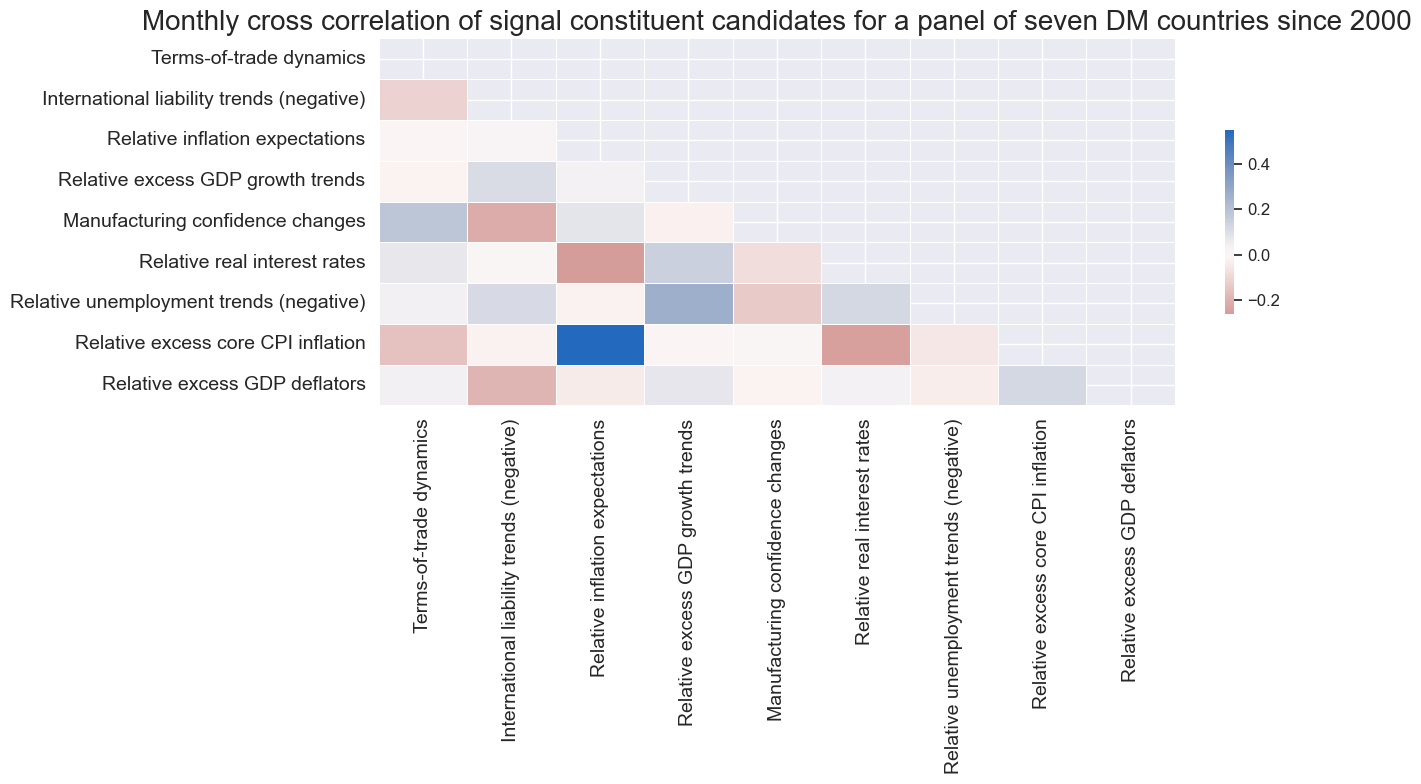

In [25]:
cidx = cids_dmfx
xcatx = cpoz

sdate = "2000-01-01"

renaming_dict = {
    "CTOT_NSA_PAR_ZN": "Terms-of-trade dynamics",
    "IIPLIABGDP_NSA_D_NEG_ZN": "International liability trends (negative)",
    "INFE_JAvBM_ZN": "Relative inflation expectations",
    "INTRGDP_NSA_P1M1ML12_3MMAvBM_ZN": "Relative excess GDP growth trends",
    "MBCSCORE_SA_D_ZN": "Manufacturing confidence changes",
    "RIR_NSAvBM_ZN": "Relative real interest rates",
    "UNEMPLRATE_SA_DvBM_NEG_ZN": "Relative unemployment trends (negative)",
    "XCPIXFE_SA_PARvBM_ZN": "Relative excess core CPI inflation",
    "XPGDPTECH_SA_P1M1ML12_3MMAvBM_ZN": "Relative excess GDP deflators",
}

dfx_corr = dfx.copy()

for key, value in renaming_dict.items():
    dfx_corr["xcat"] = dfx_corr["xcat"].str.replace(key, value)

msp.correl_matrix(
    dfx_corr,
    xcats=list(renaming_dict.values()),
    cids=cidx,
    start=sdate,
    freq="M",
    cluster=False,
    title="Monthly cross correlation of signal constituent candidates for a panel of seven DM countries since 2000",
    size=(14, 8),
)

## Signal preparations

### Conceptual parity as benchmark

[`linear_composite`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#calculate-linear-combinations-of-panels-with-linear-composite) method from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package aggregates the individual category scores into a unified (equally weighted) composite indicator `ALL_AVGZ`. `ALL_AVGZ` composite indicator serves as a benchmark for subsequent analyses, particularly in comparing its performance or relevance against signals optimized through machine learning techniques. By doing so, this composite indicator becomes a standard reference point, enabling a systematic evaluation of the effectiveness of machine learning-derived signals in capturing the underlying dynamics represented by the individual category scores.

In [26]:
# Linear equally-weighted combination of all available candidates

xcatx = cpoz
cidx = cids_dmfx

dfa = msp.linear_composite(
    df=dfx,
    xcats=cpoz,
    cids=cidx,
    new_xcat="ALL_AVGZ",
)
dfx = msm.update_df(dfx, dfa)

### Convert data to scikit-learn format

Downsampling daily information states to a monthly frequency is a common preparation step for machine learning models, especially when dealing with financial and economic time series data. The [categories_df()](https://github.com/macrosynergy/macrosynergy/blob/develop/macrosynergy/management/utils/df_utils.py#L608) function applies the leg of 1 month and uses the last value in the month for explanatory variables and the sum for the aggregated target (return). As explanatory variables, we use plausible z-scores of economic variables derived earlier and collected in the list `cpos`. As a target, we use  `FXXR_VT10`,  FX forward return for 10% vol target: dominant cross.

In [27]:
cidx = cids_dmfx
xcatx = cpoz + ["FXXR_VT10"]

# Downsample from daily to monthly frequency (features as last and target as sum)
dfw = msm.categories_df(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq="M",
    lag=1,
    blacklist=fxblack,
    xcat_aggs=["last", "sum"],
)

# Drop rows with missing values and assign features and target
dfw.dropna(inplace=True)
X_fx = dfw.iloc[:, :-1]
y_fx = dfw.iloc[:, -1]

### Define splitter and scorer

The [RollingKFoldPanelSplit](https://github.com/macrosynergy/macrosynergy/blob/develop/macrosynergy/learning/panel_time_series_split.py#L332) class instantiates splitters where temporally adjacent panel training sets of fixed joint maximum time spans can border the test set from both the past and future. Thus, most folds do not respect the chronological order but allow training with past and future information. While this does not simulate the evolution of information, it makes better use of the available data and is often acceptable for macro data as economic regimes come in cycles. It is equivalent to `scikit-learn`’s [Kfold class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) but adapted for panels.

The standard [`make_scorer()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function from the [`scikit-learn`](https://scikit-learn.org/stable/) library is used to create a scorer object that is used to evaluate the performance on the test set. The standard `r2_score` function is used as a scorer.

In [28]:
splitter = msl.RollingKFoldPanelSplit(n_splits=5)
scorer = make_scorer(r2_score, greater_is_better=True)

The method `visualise_splits()` is a convenient method for visualizing the splits produced by each child splitter, giving the user confidence in the splits produced for their use case.

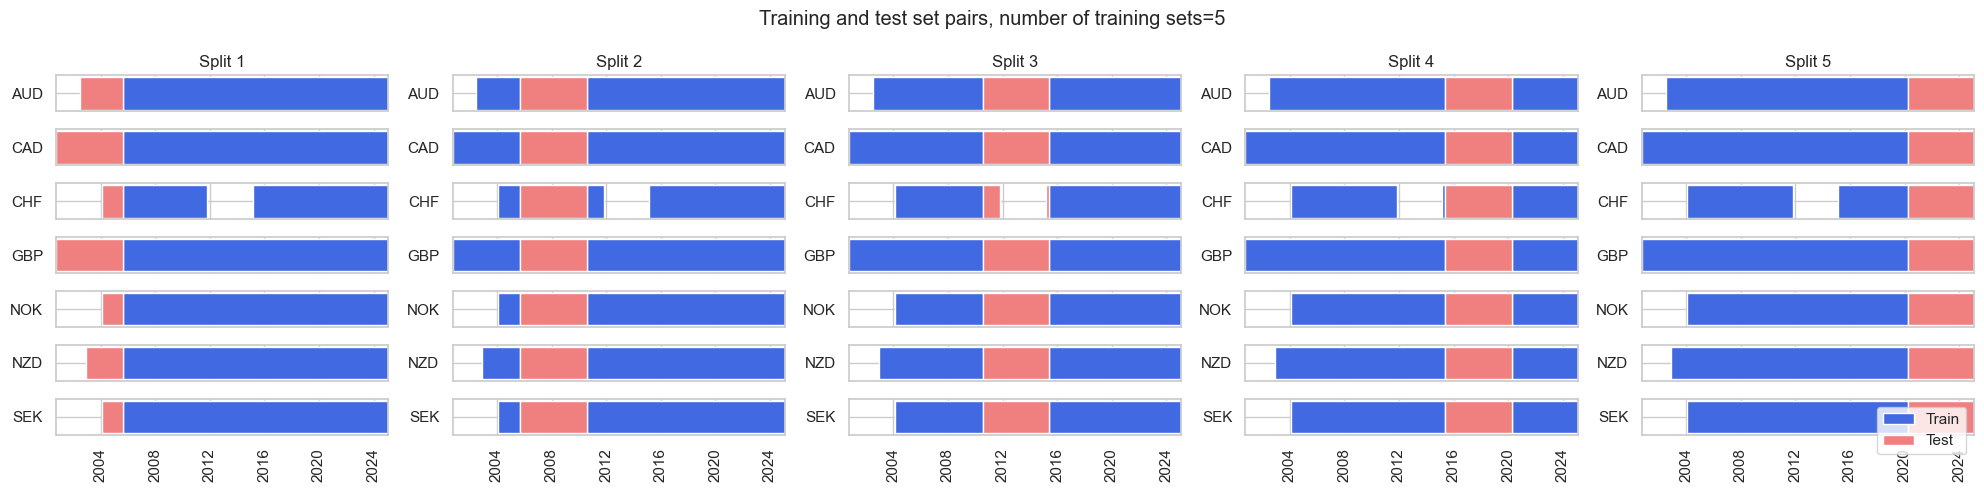

In [29]:
splitter.visualise_splits(X_fx, y_fx)

## OLS/NNLS regression-based learning

### Sequential optimization and analysis

For a straightforward Ordinary Least Squares (OLS) learning process,  employing the [`LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from [`scikit-learn`](https://scikit-learn.org/stable/) offers a streamlined and efficient approach to regression analysis. When setting up this model for machine learning, two hyperparameter decisions can significantly influence the model's behavior and its interpretation of the data:

-	Non-negativity constraint: This offers the option of non-negative least squares (NNLS), rather than simple OLS. NNLS imposes the constraint that the coefficients must be non-negative. The benefit of this restriction is that it allows consideration of theoretical priors on the direction of impact, reducing dependence on scarce data.

-	Inclusion of a regression intercept: Conceptually the neutral level of all (mostly relative) signal constituent candidates is zero. Hence, the regression intercept is presumed to be zero, albeit that may not always be exact, and some theoretical assumptions may have been wrong.



In [30]:
# Specify model options and grids

mods_ols = {
    "ls": LinearRegression(),
}

grid_ols = {
    "ls": {"positive": [True, False], "fit_intercept": [True, False]},
}

[`SignalOptimizer`](https://github.com/macrosynergy/macrosynergy/blob/develop/macrosynergy/learning/signal_optimizer.py) class from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is a sophisticated tool designed to facilitate the process of optimizing and evaluating different signals (predictors) for forecasting models in a time series context. Leveraging the earlier defined cross-validation split (`RollingKFoldPanelSplit`), the blacklist period, defined data frames of dependent and independent variables, and a few other optional parameters, we instantiate the `SignalOptimizer` class.

`calculate_predictions()` method is used to calculate, store and return sequentially optimized signals for a given process. This method implements the nested cross-validation and subsequent signal generation. The name of the process, together with models to fit, hyperparameters to search over and a metric to optimize, are provided as compulsory arguments.

In [31]:
xcatx = cpoz + ["FXXR_VT10"]
cidx = cids_dmfx

so_ls = msl.SignalOptimizer(
    df = dfx,
    xcats = xcatx,
    cids = cidx,
    blacklist = fxblack,
    freq = "M",
    lag = 1,
    xcat_aggs = ["last", "sum"]
)

In [32]:
so_ls.calculate_predictions(
    name = "LS",
    models = mods_ols,
    hyperparameters = grid_ols,
    scorers = {"r2": scorer},
    inner_splitters = {"Rolling": splitter},
    search_type = "grid",
    normalize_fold_results = False,
    cv_summary = "mean",
    min_cids = 2,
    min_periods = 36,
    test_size = 1,
    n_jobs_outer = -1,
    split_functions={"Rolling": lambda n: n // 36},
)

dfa = so_ls.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/256 [00:00<?, ?it/s]

The "heatmap" serves as a powerful tool to illustrate the evolution and selection of predictive models over time, especially in a context. When the visualization indicates that over time the preferred model becomes the most restrictive one, it suggests a shift towards models with tighter constraints or fewer degrees of freedom. 

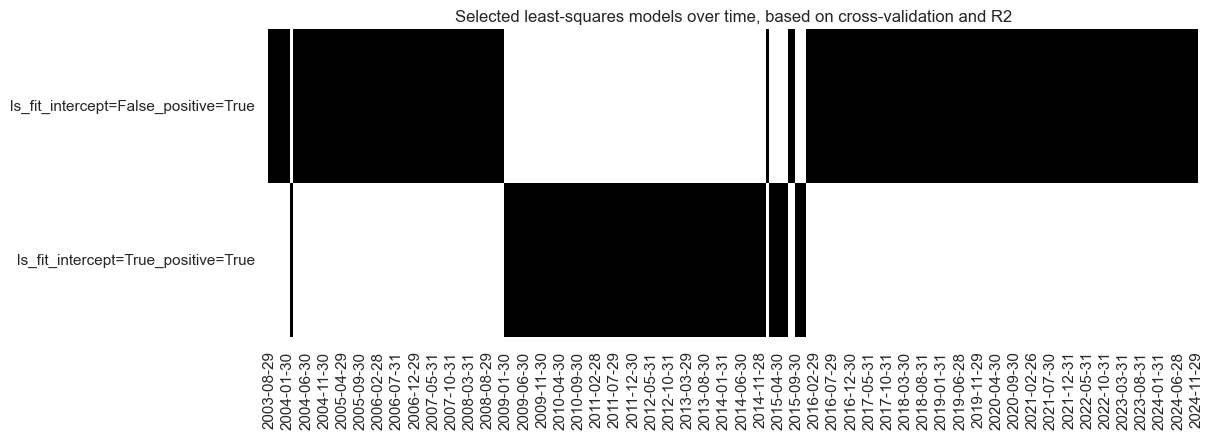

In [33]:
so_ls.models_heatmap(
    name="LS",
    cap=6,
    title="Selected least-squares models over time, based on cross-validation and R2",
    figsize=(12, 4),
)

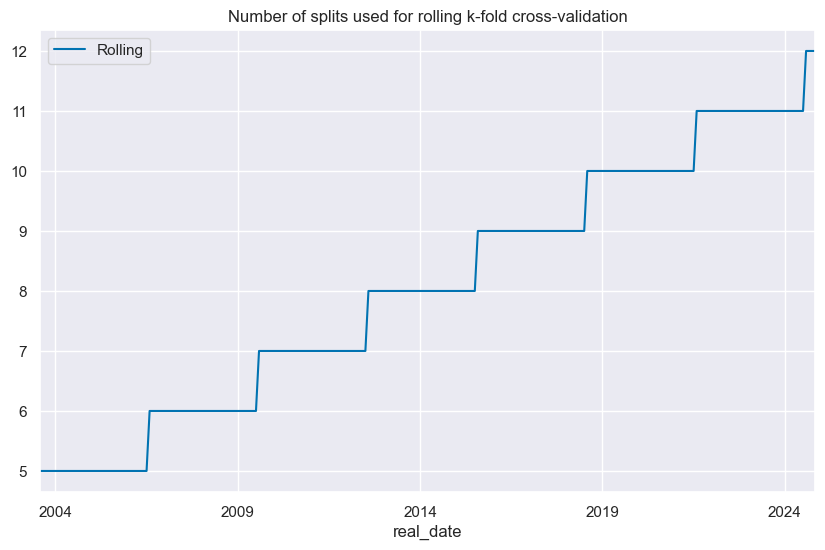

In [34]:
# Number of splits used for cross-validation over time

so_ls.nsplits_timeplot("LS", title="Number of splits used for rolling k-fold cross-validation")

The `feature_importance_timeplot()` method is designed for plotting the time series of feature coefficients obtained from regression models over time. This kind of visualization can be particularly valuable to understand the dynamics and stability of model coefficients, which is crucial for interpretation and forecasting.

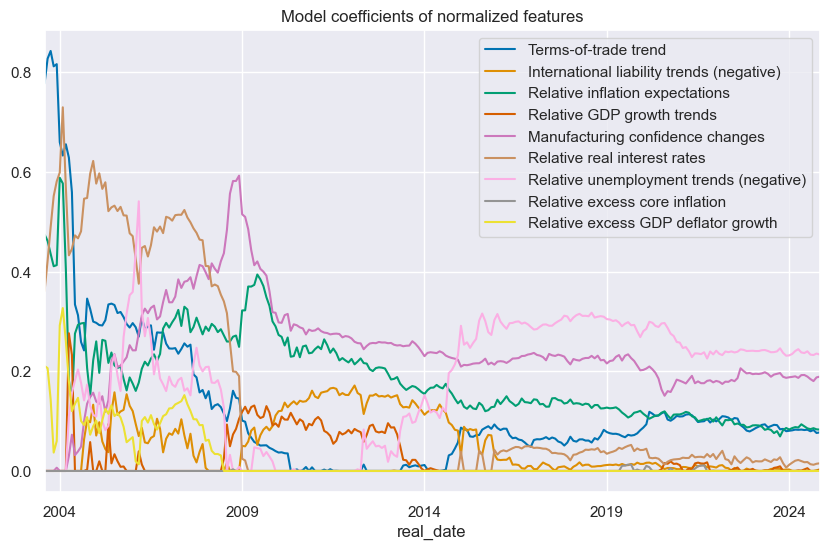

In [35]:
ftrs_dict = {
    "CTOT_NSA_PAR_ZN": "Terms-of-trade trend",
    "IIPLIABGDP_NSA_D_NEG_ZN": "International liability trends (negative)",
    "INFE_JAvBM_ZN": "Relative inflation expectations",
    "INTRGDP_NSA_P1M1ML12_3MMAvBM_ZN": "Relative GDP growth trends",
    "MBCSCORE_SA_D_ZN": "Manufacturing confidence changes",
    "RIR_NSAvBM_ZN": "Relative real interest rates",
    "UNEMPLRATE_SA_DvBM_NEG_ZN": "Relative unemployment trends (negative)",
    "XCPIXFE_SA_PARvBM_ZN": "Relative excess core inflation",
    "XPGDPTECH_SA_P1M1ML12_3MMAvBM_ZN": "Relative excess GDP deflator growth",
}

so_ls.feature_importance_timeplot("LS", title="Model coefficients of normalized features",ftrs_renamed=ftrs_dict)

`coefs_stackedbarplot()` is another convenient function, generating stacked bar plots to visualize the coefficients of features from regression models. This visualization method effectively displays the magnitude and direction of each feature's influence on the outcome, allowing for easy comparison and interpretation of how different predictors contribute to the model.

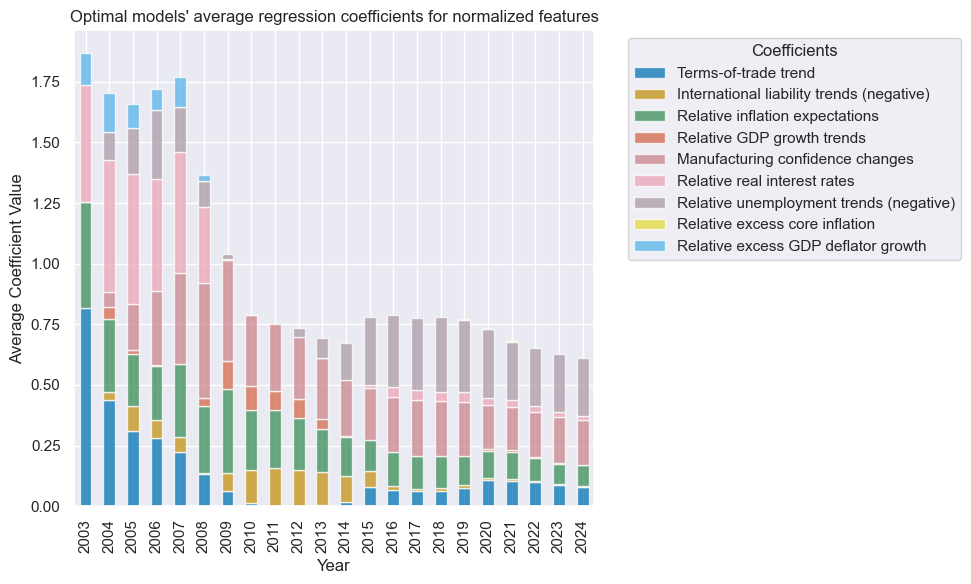

In [36]:
so_ls.coefs_stackedbarplot("LS", 
                           title="Optimal models' average regression coefficients for normalized features",
                           ftrs_renamed=ftrs_dict)

The `intercepts_timeplot()` function is designed to plot the time series of intercepts from regression models, enabling an analysis of how the model intercepts change over time. 

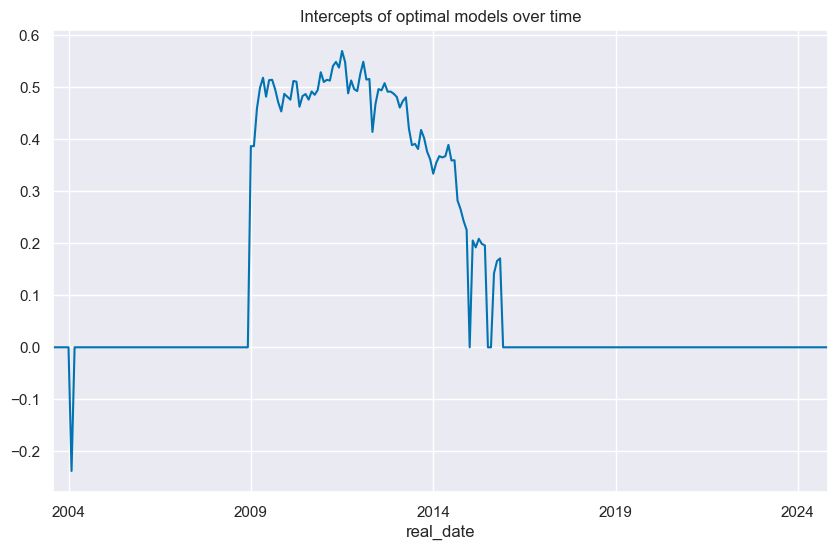

In [37]:
so_ls.intercepts_timeplot("LS",
                          title="Intercepts of optimal models over time")

To display and compare the values for conceptual parity `ALL_AVGZ` versus OLS-based learning indicator `LS` we use [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) function from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package


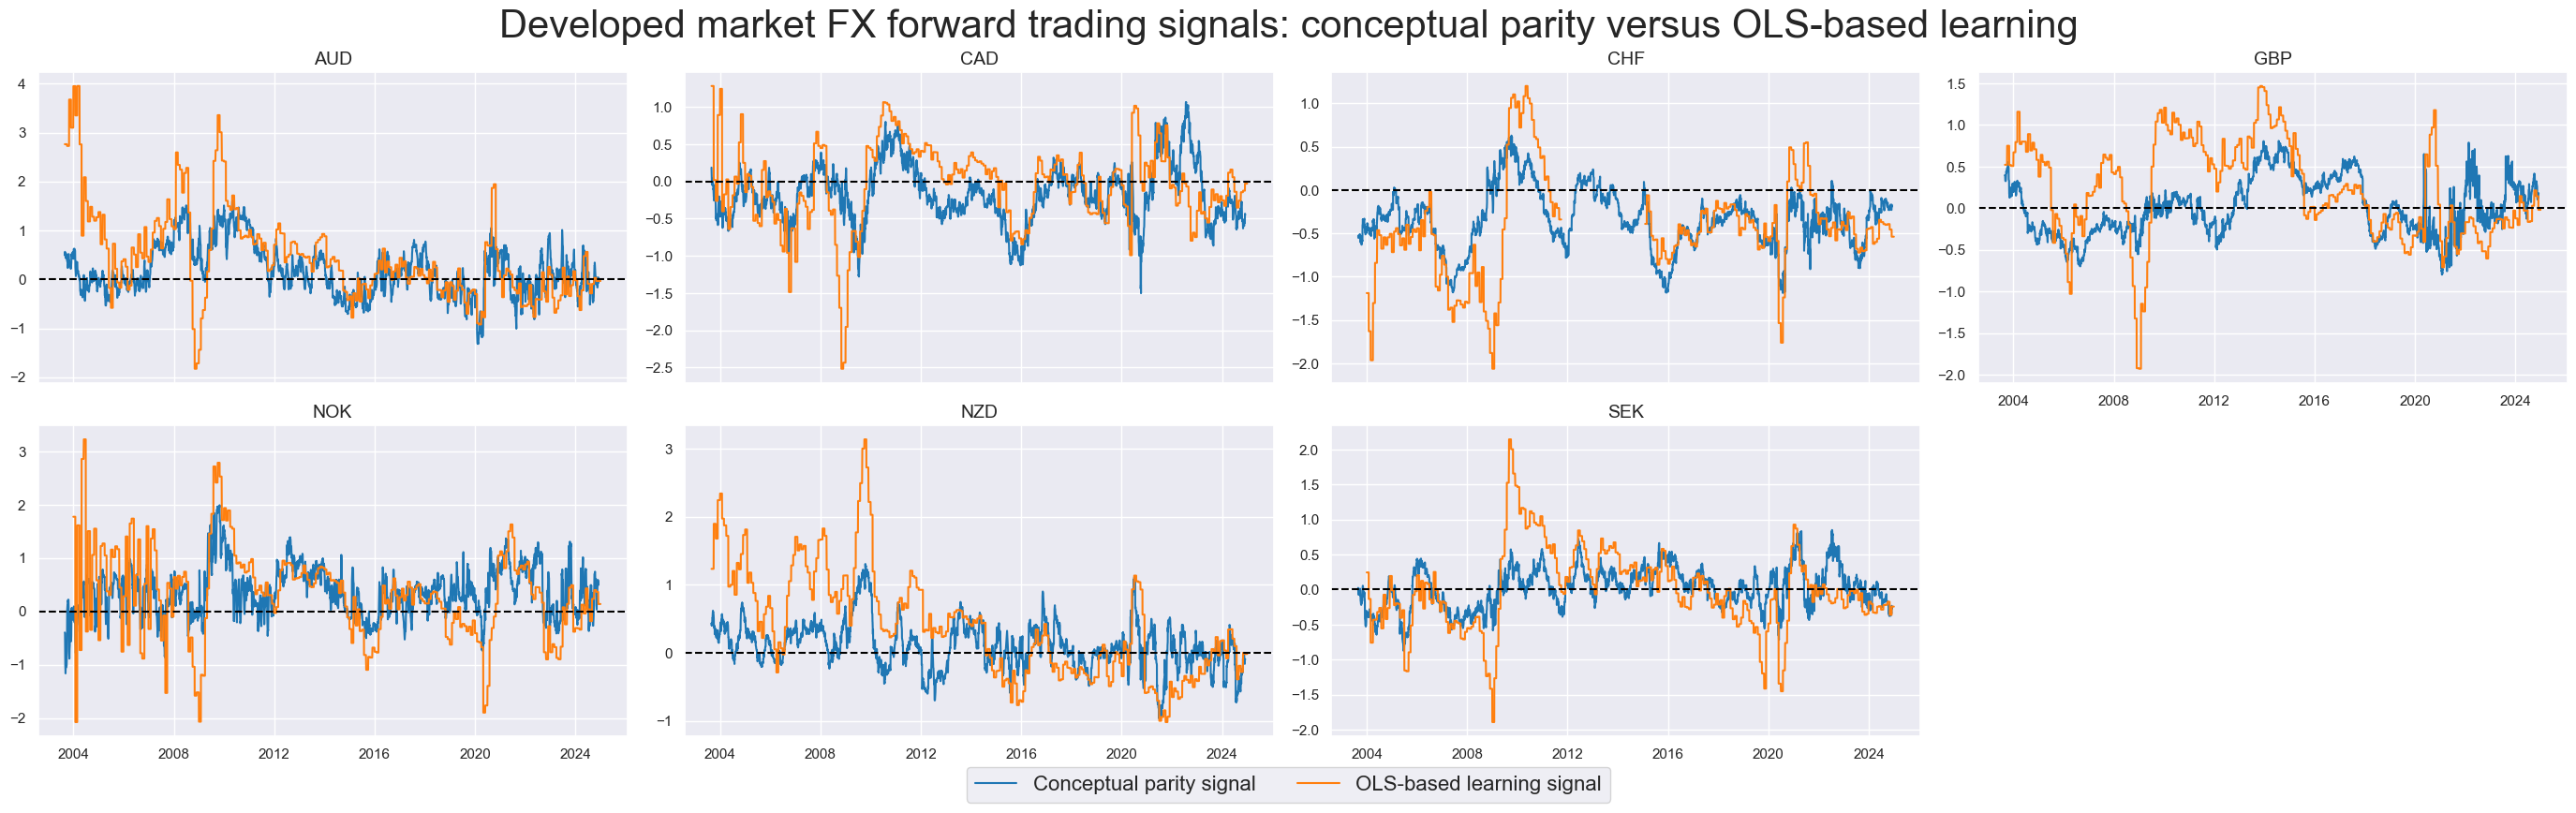

In [38]:
sigs_ls = [
    "ALL_AVGZ",
    "LS",
]
xcatx = sigs_ls
cidx = cids_dmfx

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    start="2003-08-29",
    title="Developed market FX forward trading signals: conceptual parity versus OLS-based learning",
    title_fontsize=30,
    same_y=False,
    cs_mean=False,
    xcat_labels=["Conceptual parity signal", "OLS-based learning signal"],
    legend_fontsize=16,
)

### Signal value checks

#### Specs and panel test

In [39]:
sigs = ["ALL_AVGZ", "LS"]
targs = ["FXXR_VT10"]
cidx = cids_dmfx
sdate = "2003-08-29"

dict_ls = {
    "sigs": sigs,
    "targs": targs,
    "cidx": cidx,
    "start": sdate,
    "black": fxblack,
    "srr": None,
    "pnls": None,
}

`CategoryRelations` facilitates the visualization and analysis of relationships between two specific categories, namely, two panels of time series data. This tool is used to examine the interaction between the risk parity "ALL_AVGZ", and optimized "LS" - on one side, and the FXXR_VT10, which represents the FX forward return for a 10% volatility target, focusing on the dominant cross, on the other. The `multiple_reg_scatter` method of the class displays correlation scatters for the two pairs.

The plot below shows the significant positive predictive power of the OLS learning-based signals with respect to subsequent weekly, monthly, and quarterly FX returns. The correlation coefficient for the OLS learning-based signal is considerably higher than for the risk parity version. 

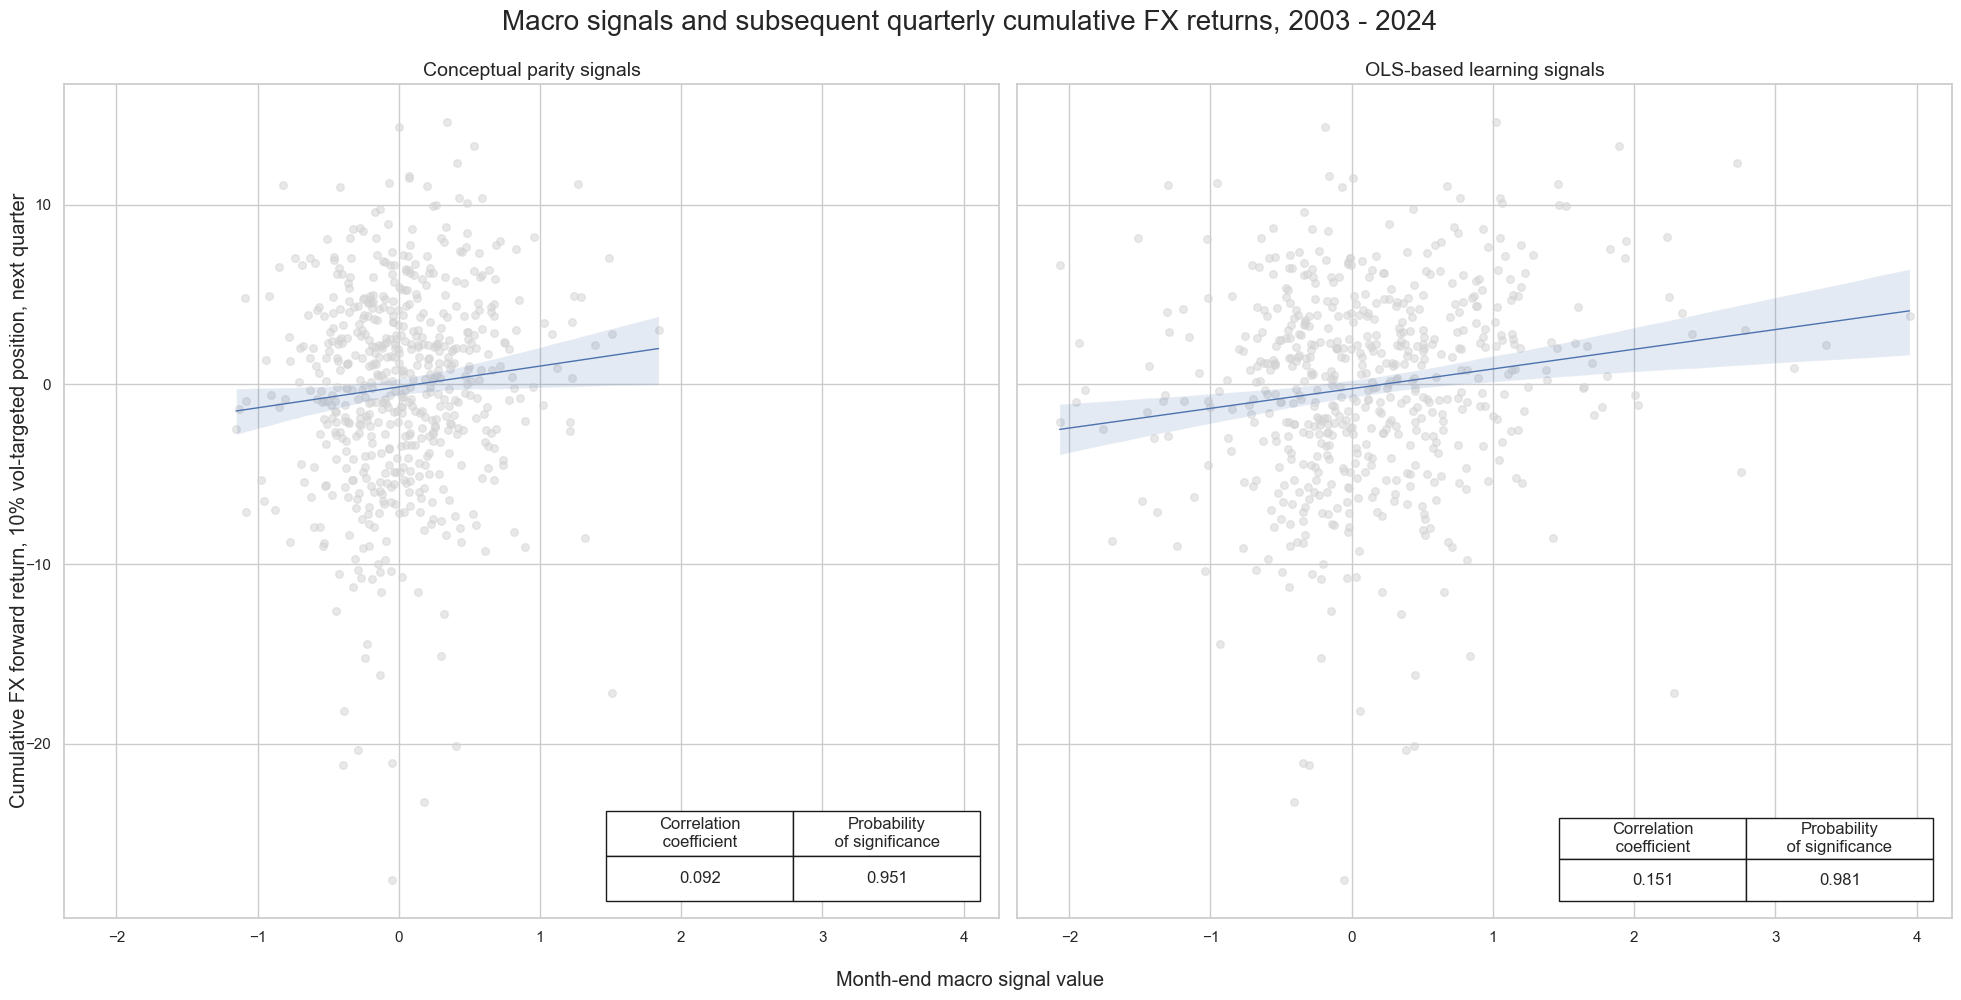

In [40]:
dix = dict_ls

sigx = dix["sigs"]
tarx = dix["targs"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

def crmaker(sig, targ):
    crx = msp.CategoryRelations(
        dfx,
        xcats=[sig, targ],
        cids=cidx,
        freq="Q",
        lag=1,
        xcat_aggs=["last", "sum"],
        start=start,
        blacklist=blax,
    )
    return crx


lcrs = [crmaker(sig, targ) for sig in sigx for targ in tarx]

msv.multiple_reg_scatter(
    lcrs,
    ncol=2,
    nrow=1,
    figsize=(20, 10),
    title="Macro signals and subsequent quarterly cumulative FX returns, 2003 - 2024",
    xlab="Month-end macro signal value",
    ylab="Cumulative FX forward return, 10% vol-targeted position, next quarter",
    coef_box="lower right",
    prob_est="map",
    subplot_titles=["Conceptual parity signals", "OLS-based learning signals"],
)

#### Accuracy and correlation check

The [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class of the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package  is specifically designed to assess the predictive power of signal categories in determining the direction of subsequent returns, particularly for data structured in the JPMaQS format. This class provides a streamlined approach for evaluating how well a given signal can forecast future market movements, offering insights for investment strategies, risk management, and economic analysis. It helps to identify which indicators have more predictive power.

In [41]:
## Compare optimized signals with simple average z-scores

dix = dict_ls

sigx = dix["sigs"]
tarx = dix["targs"]
cidx = dix["cidx"]
blax = dix["black"]
startx = dix["start"]

srr = mss.SignalReturnRelations(
    df=dfx,
    rets=tarx,
    sigs=sigx,
    cids=cidx,
    cosp=True,
    freqs=["M"],
    agg_sigs=["last"],
    start=startx,
    blacklist=blax,
    slip=1,
    ms_panel_test=True,
)
dix["srr"] = srr

In [42]:
srr = dict_ls["srr"]

selcols = [
    "accuracy",
    "bal_accuracy",
    "pos_sigr",
    "pos_retr",
    "pearson",
    "map_pval",
    "kendall",
    "kendall_pval",
]


In [43]:
srr.multiple_relations_table().round(3)[selcols]

accuracy  bal_accuracy  pos_sigr  \
Return    Signal   Frequency Aggregation                                     
FXXR_VT10 ALL_AVGZ M         last            0.526         0.526     0.495   
          LS       M         last            0.535         0.535     0.530   

                                          pos_retr  pearson  map_pval  \
Return    Signal   Frequency Aggregation                                
FXXR_VT10 ALL_AVGZ M         last            0.505    0.057     0.027   
          LS       M         last            0.505    0.095     0.016   

                                          kendall  kendall_pval  
Return    Signal   Frequency Aggregation                         
FXXR_VT10 ALL_AVGZ M         last           0.044         0.006  
          LS       M         last           0.070         0.000

#### Naive PnL

In this analysis, the notebook calculates the naive Profit and Loss (PnL) for foreign exchange (FX) strategies utilizing both risk parity and OLS-based learning indicators. These PnL calculations are derived from simple trading strategies that interpret the indicators as signals to either go long (buy) or short (sell) FX positions. Specifically, the direction of the indicators guides the trading decisions, where a positive signal might suggest buying (going long) the FX asset, and a negative signal might suggest selling (going short). This approach allows for a direct evaluation of how effectively each indicator—risk parity and OLS-based—can predict profitable trading opportunities in the FX market.

Please refer to [`NaivePnl() class`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) for details.

In [44]:
dix = dict_ls

sigx = dix["sigs"]
tarx = dix["targs"]
cidx = dix["cidx"]
blax = dix["black"]
startx = dix["start"]

pnls = msn.NaivePnL(
    df=dfx,
    ret=tarx[0],
    sigs=sigx,
    cids=cidx,
    start=startx,
    blacklist=blax,
    bms=["USD_GB10YXR_NSA", "EUR_FXXR_NSA", "USD_EQXR_NSA"],
)
for sig in sigx:
    pnls.make_pnl(
        sig=sig,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=10,
        thresh=4,
    )
pnls.make_long_pnl(vol_scale=10, label="Long only")

dix["pnls"] = pnls

The PnLs are plotted using `.plot_pnls()` method of the [`NaivePnl()` class](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl). The performance characteristics of the learning-based signal are encouraging. One should consider that the strategy only has seven markets to trade in, some of which are highly correlated. Also, the strategy only macro signals, without any other consideration of market prices and volumes. Position changes are infrequent and gentle.

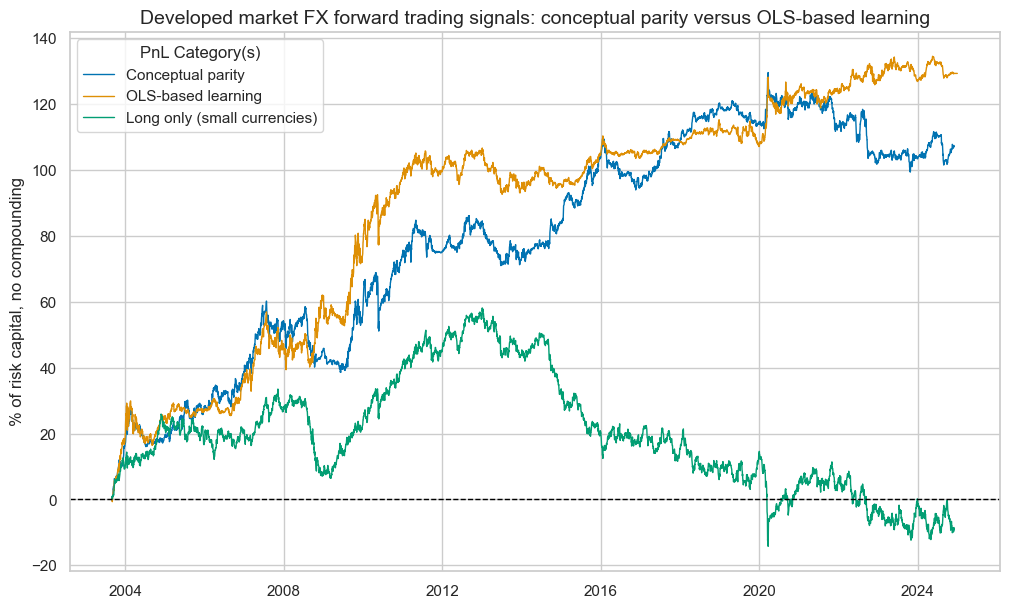

xcat                     PNL_ALL_AVGZ     PNL_LS  Long only
Return %                     5.049094   6.054965  -0.433958
St. Dev. %                       10.0       10.0       10.0
Sharpe Ratio                 0.504909   0.605497  -0.043396
Sortino Ratio                0.711546    0.85664  -0.059703
Max 21-Day Draw %            -17.7254 -15.013328 -23.133937
Max 6-Month Draw %         -14.745215 -14.601964 -22.868546
Peak to Trough Draw %      -30.190283 -17.516423 -72.266181
Top 5% Monthly PnL Share     0.741356   0.577154  -8.061563
USD_GB10YXR_NSA correl      -0.088757  -0.072222  -0.012885
EUR_FXXR_NSA correl           0.13088   0.140748   0.409875
USD_EQXR_NSA correl          0.120495   0.032309   0.245412
Traded Months                     257        257        257

In [45]:
pnls = dix["pnls"]
sigx = dix["sigs"]

pnls.plot_pnls(
    title="Developed market FX forward trading signals: conceptual parity versus OLS-based learning",
    title_fontsize=14,
    xcat_labels=["Conceptual parity", "OLS-based learning", "Long only (small currencies)"],
)
pnls.evaluate_pnls(pnl_cats=["PNL_" + sig for sig in sigx] + ["Long only"])

## Alternative models of regression-based learning

### Regularized linear model (elastic net)

Beyond simple OLS regression-based learning the post considers three other types of regression-based learning processes. 

The first alternative model is Regularized regression-based learning [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

In [46]:
# Specify model options and grids

mods_en = {
    "en": ElasticNet(),
    "ls": LinearRegression(),
}

grid_en = {
    "en": {
        "positive": [True, False],
        "fit_intercept": [True, False],
        "alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1],
        "l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9]
    },
    "ls": {
        "positive": [True, False],
        "fit_intercept": [True, False],
    }
}

For the ElasticNet model, similar to the OLS regression approach, [`SignalOptimizer`](https://github.com/macrosynergy/macrosynergy/blob/develop/macrosynergy/learning/signal_optimizer.py) class from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is instantiated using earlier defined cross-validation split (`RollingKFoldPanelSplit`), blacklist period, dataframes of dependent and independent variables and a few other optional parameters.

`calculate_predictions()` method is used to calculate, store and return sequentially optimized signals for a given process. This method implements the nested cross-validation and subsequent signal generation. The name of the process, together with models to fit, hyperparameters to search over and a metric to optimize, are provided as compulsory arguments.

In [47]:
xcatx = cpoz + ["FXXR_VT10"]
cidx = cids_dmfx

so_en = msl.SignalOptimizer(
    df = dfx,
    xcats = xcatx,
    cids = cidx,
    blacklist = fxblack,
    freq = "M",
    lag = 1,
    xcat_aggs = ["last", "sum"]
)

In [48]:
so_en.calculate_predictions(
    name = "EN",
    models = mods_en,
    hyperparameters = grid_en,
    scorers = {"r2": scorer},
    inner_splitters = {"Rolling": splitter},
    search_type = "grid",
    normalize_fold_results = False,
    cv_summary = "mean",
    min_cids = 2,
    min_periods = 36,
    test_size = 1,
    n_jobs_outer = -1,
    split_functions={"Rolling": lambda n: n // 36},
)

dfa = so_en.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/256 [00:00<?, ?it/s]

The "heatmap" serves as a powerful tool to illustrate the evolution and selection of predictive models over time. 

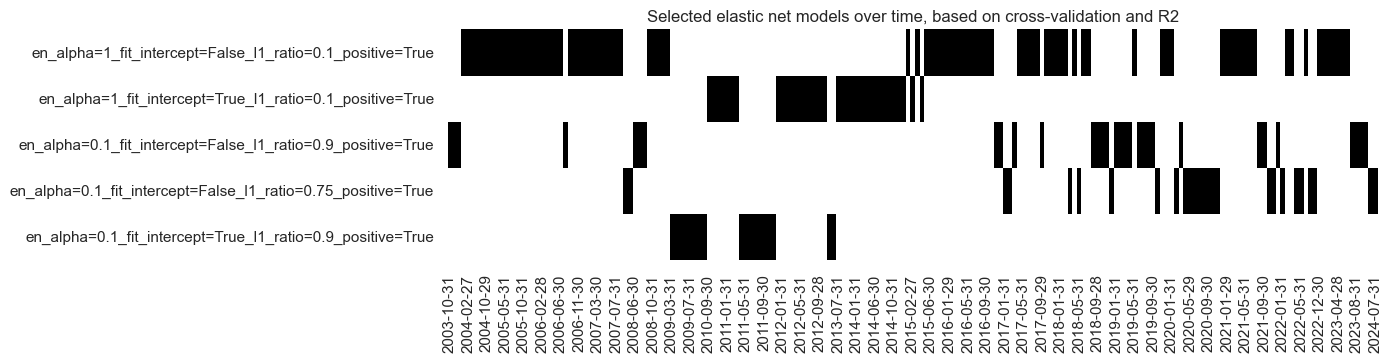

In [49]:
# Illustrate model choice

so_en.models_heatmap(
    "EN",
    title="Selected elastic net models over time, based on cross-validation and R2",
    figsize=(12, 3),
)


The `feature_importance_timeplot()` function is used to plot the time series of feature coefficients, providing a visual representation of how the importance or influence of each feature in the model changes over time. 

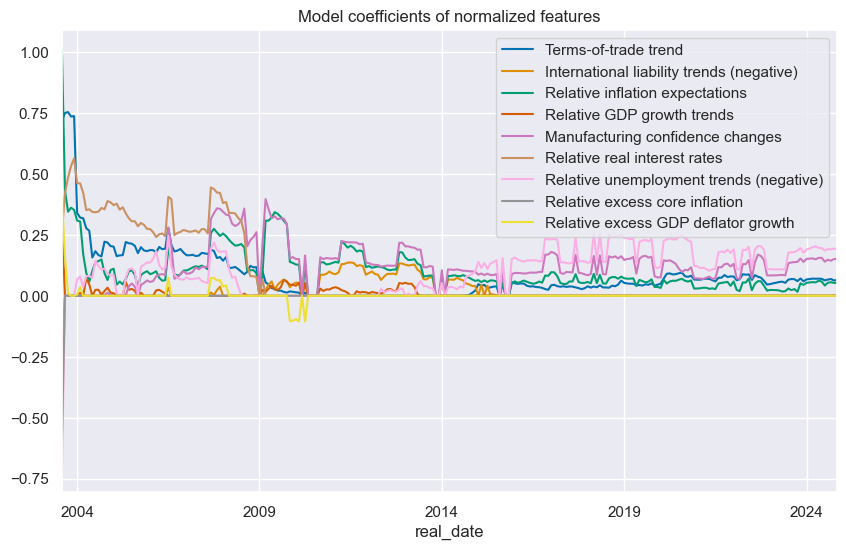

In [50]:
so_en.feature_importance_timeplot("EN", title="Model coefficients of normalized features", ftrs_renamed=ftrs_dict)

`coefs_stackedbarplot()` is another convenient function, allowing to create a stacked bar plot of feature coefficients.

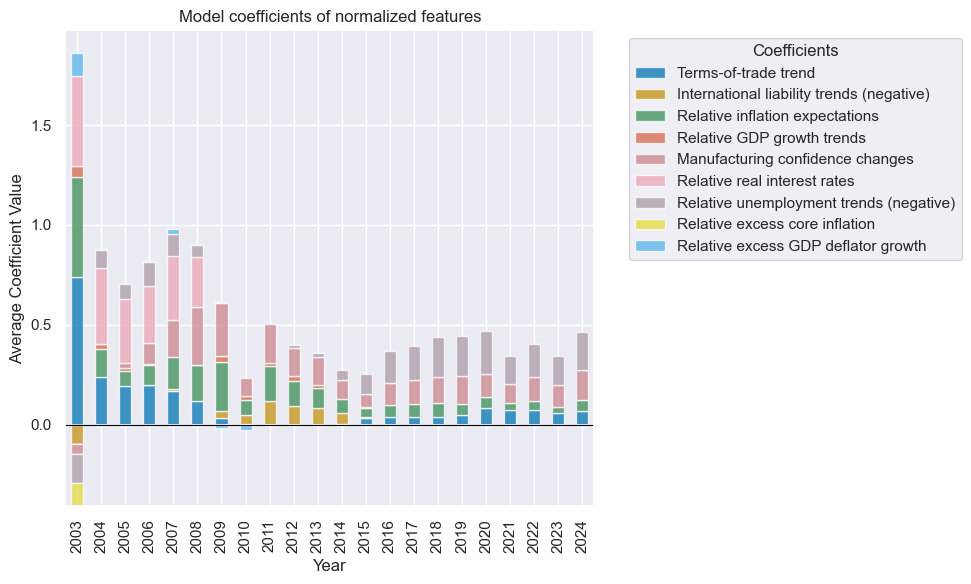

In [51]:
so_en.coefs_stackedbarplot("EN", title="Model coefficients of normalized features", ftrs_renamed=ftrs_dict)

`intercepts_timeplot()` plots the time series of intercepts.

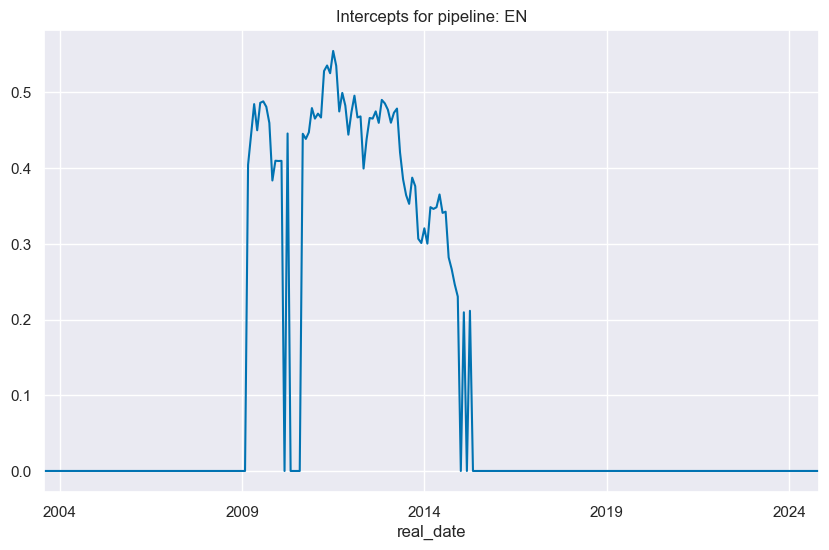

In [52]:
so_en.intercepts_timeplot("EN")

### Sign-weighted linear regression

The second alternative machine learning model is sign-weighted WLS linear regression. Sign-weighted least squares equalize the contribution of positive and negative target samples to the model fit. The learning process can choose between sign-weighted and ordinary least squares, both with intercept exclusion and non-negativity constraints. `SignWeightedLinearRegression` is a custom class to create a WLS linear regression model, with the sample weights chosen by inverse frequency of the label's sign in the training set. 

As for simple OLS regression, two hyperparameter decisions need to be made:

-   Non-negativity constraint: This offers the option of non-negative least squares (NNLS), rather than simple OLS. NNLS imposes the constraint that the coefficients must be non-negative. The benefit of this restriction is that it allows for the consideration of theoretical priors on the direction of impact, reducing dependence on scarce data.

-   Inclusion of a regression intercept: Conceptually the neutral level of all (mostly relative) signal constituent candidates is zero. Hence, the regression intercept is presumed to be zero, albeit that may not always be exact, and some theoretical assumptions may have been wrong.

In [53]:
# Specify model options and grids

mods_sw = {
    "swls": msl.SignWeightedLinearRegression(),
    "ls": LinearRegression(),
}

grid_sw = {
    "swls": {"positive": [True, False], "fit_intercept": [True, False]},
    "ls": {"positive": [True, False], "fit_intercept": [True, False]},
}

[`SignalOptimizer`](https://github.com/macrosynergy/macrosynergy/blob/develop/macrosynergy/learning/signal_optimizer.py) class from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is instantiated using earlier defined cross-validation split (RollingKFoldPanelSplit), blacklist period, dataframes of dependent and independent variables and few other optional parameters.

`calculate_predictions()` method is used to calculate, store and return sequentially optimized signals for a given process. This method implements the nested cross-validation and subsequent signal generation. The name of the process, together with models to fit, hyperparameters to search over and a metric to optimize, are provided as compulsory arguments.

In [54]:
xcatx = cpoz + ["FXXR_VT10"]
cidx = cids_dmfx

so_sw = msl.SignalOptimizer(
    df = dfx,
    xcats = xcatx,
    cids = cidx,
    blacklist = fxblack,
    freq = "M",
    lag = 1,
    xcat_aggs = ["last", "sum"]
)

In [55]:
so_sw.calculate_predictions(
    name = "SW",
    models = mods_sw,
    hyperparameters = grid_sw,
    scorers = {"r2": scorer},
    inner_splitters = {"Rolling": splitter},
    search_type = "grid",
    normalize_fold_results = False,
    cv_summary = "mean",
    min_cids = 2,
    min_periods = 36,
    test_size = 1,
    n_jobs_outer = -1,
    split_functions={"Rolling": lambda n: n // 36},
)

dfa = so_sw.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/256 [00:00<?, ?it/s]

The "heatmap" serves as a powerful tool to illustrate the evolution and selection of predictive models over time:

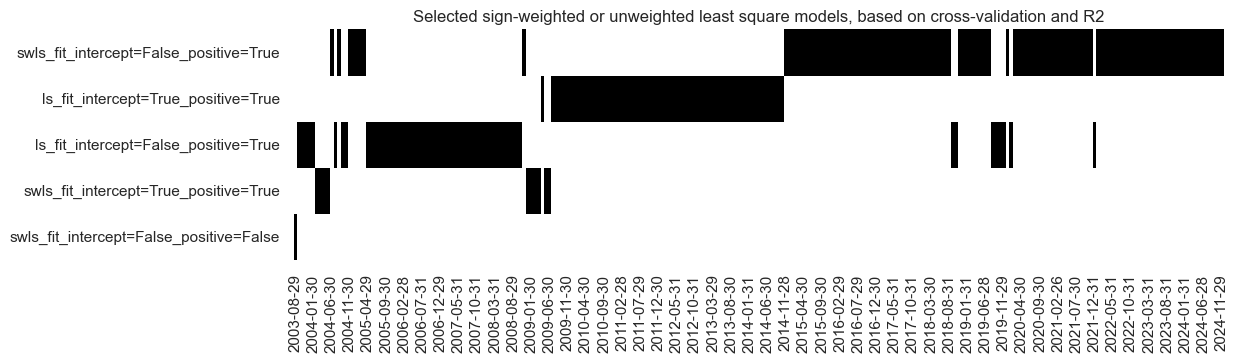

In [56]:
# Illustrate model choice

so_sw.models_heatmap(
    "SW",
    title="Selected sign-weighted or unweighted least square models, based on cross-validation and R2",
    figsize=(12, 3),
)

### Time-weighted regression

The last alternative machine learning model is time-weighted regression-based learning. Time-Weighted Least Squares allow prioritizing more recent information in the model fit by defining a half-life of exponential decay in units of the native dataset frequency. The learning process can choose between time-weighted and ordinary least squares. `TimeWeightedLinearRegression` is a custom class to create a WLS linear regression model, where the training sample weights exponentially decay by sample recency, given a prescribed half_life.

Key hyperparameters of this model are: 

-  Non-negativity constraint: option of non-negative least squares (NNLS), rather than simple OLS
- Inclusion of a regression intercept: decides whether to include an intercept, acknowledging cases where the assumption of a zero neutral level might not hold.
- Half-life specification: defines the decay rate for weighting recent observations more heavily, with a selectable range between 12 to 240 months, adapting the model to the specific temporal sensitivity of the dataset.

In [57]:
# Specify model options and grids

mods_tw = {
    "twls": msl.TimeWeightedLinearRegression(),
    "ls": LinearRegression(),
}

grid_tw = {
    "twls": {"positive": [True, False], "fit_intercept": [True, False], "half_life": [12, 24, 36, 60, 120, 240]},
    "ls": {"positive": [True, False], "fit_intercept": [True, False]},
}

[`SignalOptimizer`](https://github.com/macrosynergy/macrosynergy/blob/develop/macrosynergy/learning/signal_optimizer.py) class from the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is instantiated using a time-respecting cross-validator split (`ExpandingKFoldPanelSplit`), blacklist period, dataframes of dependent and independent variables and few other optional parameters. This expanding splitter is required because the model takes into account the sequential component of the panel.

`calculate_predictions()` method is used to calculate, store and return sequentially optimized signals for a given process. This method implements the nested cross-validation and subsequent signal generation. The name of the process, together with models to fit, hyperparameters to search over and a metric to optimize, are provided as compulsory arguments.

In [58]:
xcatx = cpoz + ["FXXR_VT10"]
cidx = cids_dmfx

so_tw = msl.SignalOptimizer(
    df = dfx,
    xcats = xcatx,
    cids = cidx,
    blacklist = fxblack,
    freq = "M",
    lag = 1,
    xcat_aggs = ["last", "sum"]
)

In [59]:
so_tw.calculate_predictions(
    name = "TW",
    models = mods_tw,
    hyperparameters = grid_tw,
    scorers = {"r2": scorer},
    inner_splitters = {"Rolling": splitter},
    search_type = "grid",
    normalize_fold_results = False,
    cv_summary = "mean",
    min_cids = 2,
    min_periods = 36,
    test_size = 1,
    n_jobs_outer = -1,
    split_functions={"Rolling": lambda n: n // 36},
)

dfa = so_tw.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/256 [00:00<?, ?it/s]

The "heatmap" serves as a powerful tool to illustrate the evolution and selection of predictive models over time

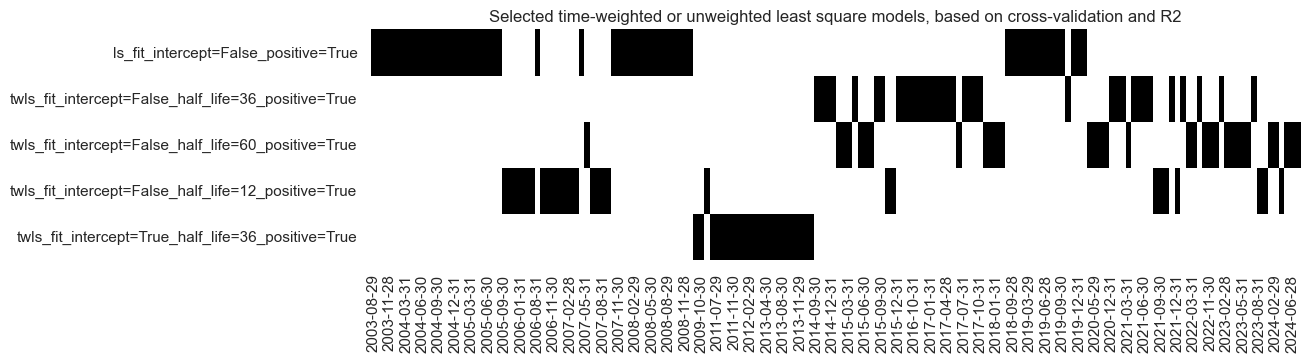

In [60]:
# Illustrate model choice

so_tw.models_heatmap(
    "TW",
    title="Selected time-weighted or unweighted least square models, based on cross-validation and R2",
    figsize=(12, 3),
)

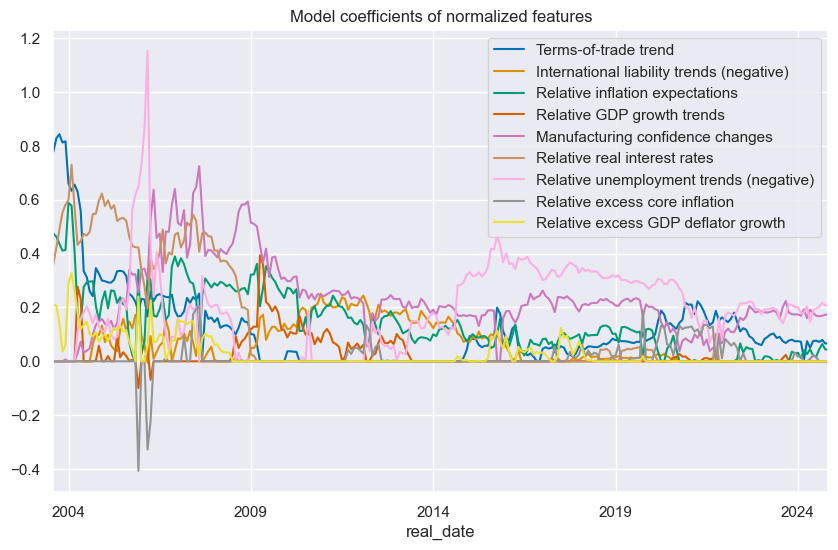

In [61]:
so_tw.feature_importance_timeplot("TW", title="Model coefficients of normalized features", ftrs_renamed=ftrs_dict)

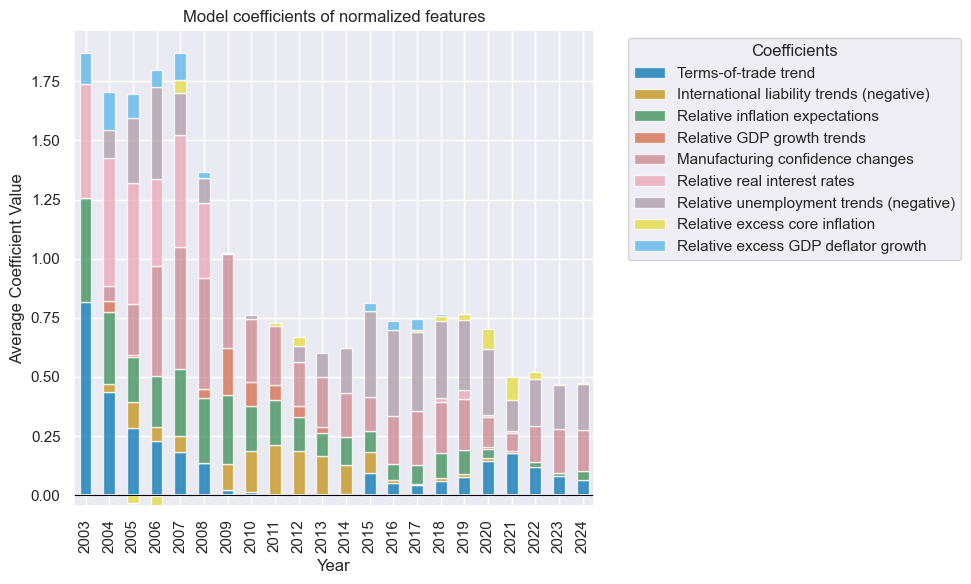

In [62]:
so_tw.coefs_stackedbarplot("TW", title="Model coefficients of normalized features", ftrs_renamed=ftrs_dict)

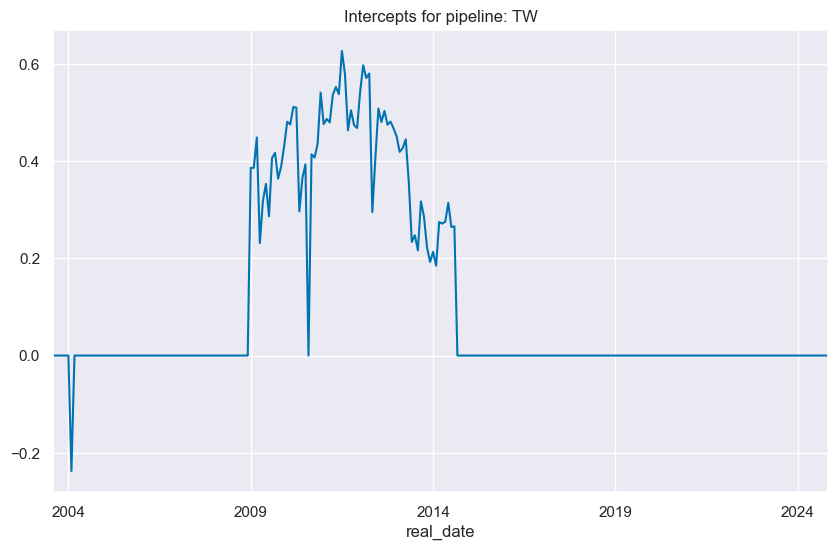

In [63]:
so_tw.intercepts_timeplot("TW")

### Signal value checks

#### Specs and panel test

This part of the notebook checks and compares the predictive powers of the three alternative regression-based learning processes:

•   Regularized regression-based learning\
•   Sign-weighted regression-based learning\
•   Time-weighted regression-based learning

with standard regression-based learning approach OLS.

This part follows the same structure as above, where we compared conceptual parity `ALL_AVGZ` versus OLS-based learning indicator `LS`. In this part, we compare the four optimized indicators generated by the above models:

- `CategoryRelations` and `multiple_reg_scatter` analyze and visualize the relationships between the four optimized signals - "LS", "EN", "SW", "TW" - on one side, and the FXXR_VT10, which represents the FX forward return for a 10% volatility target, focusing on the dominant cross, on the other.
- The [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class of the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package  assess the predictive power of the signals 
- [`NaivePnl() class`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) provides a quick and simple overview of a stylized PnL profile of a set of trading signals and plots line charts of cumulative PnLs:

In [64]:
sigs = ["ALL_AVGZ", "LS", "EN", "SW", "TW"]
targs = ["FXXR_VT10"]
cidx = cids_dmfx

dict_ams = {
    "sigs": sigs,
    "targs": targs,
    "cidx": cidx,
    "start": dix["start"],
    "black": fxblack,
    "srr": None,
    "pnls": None,
}

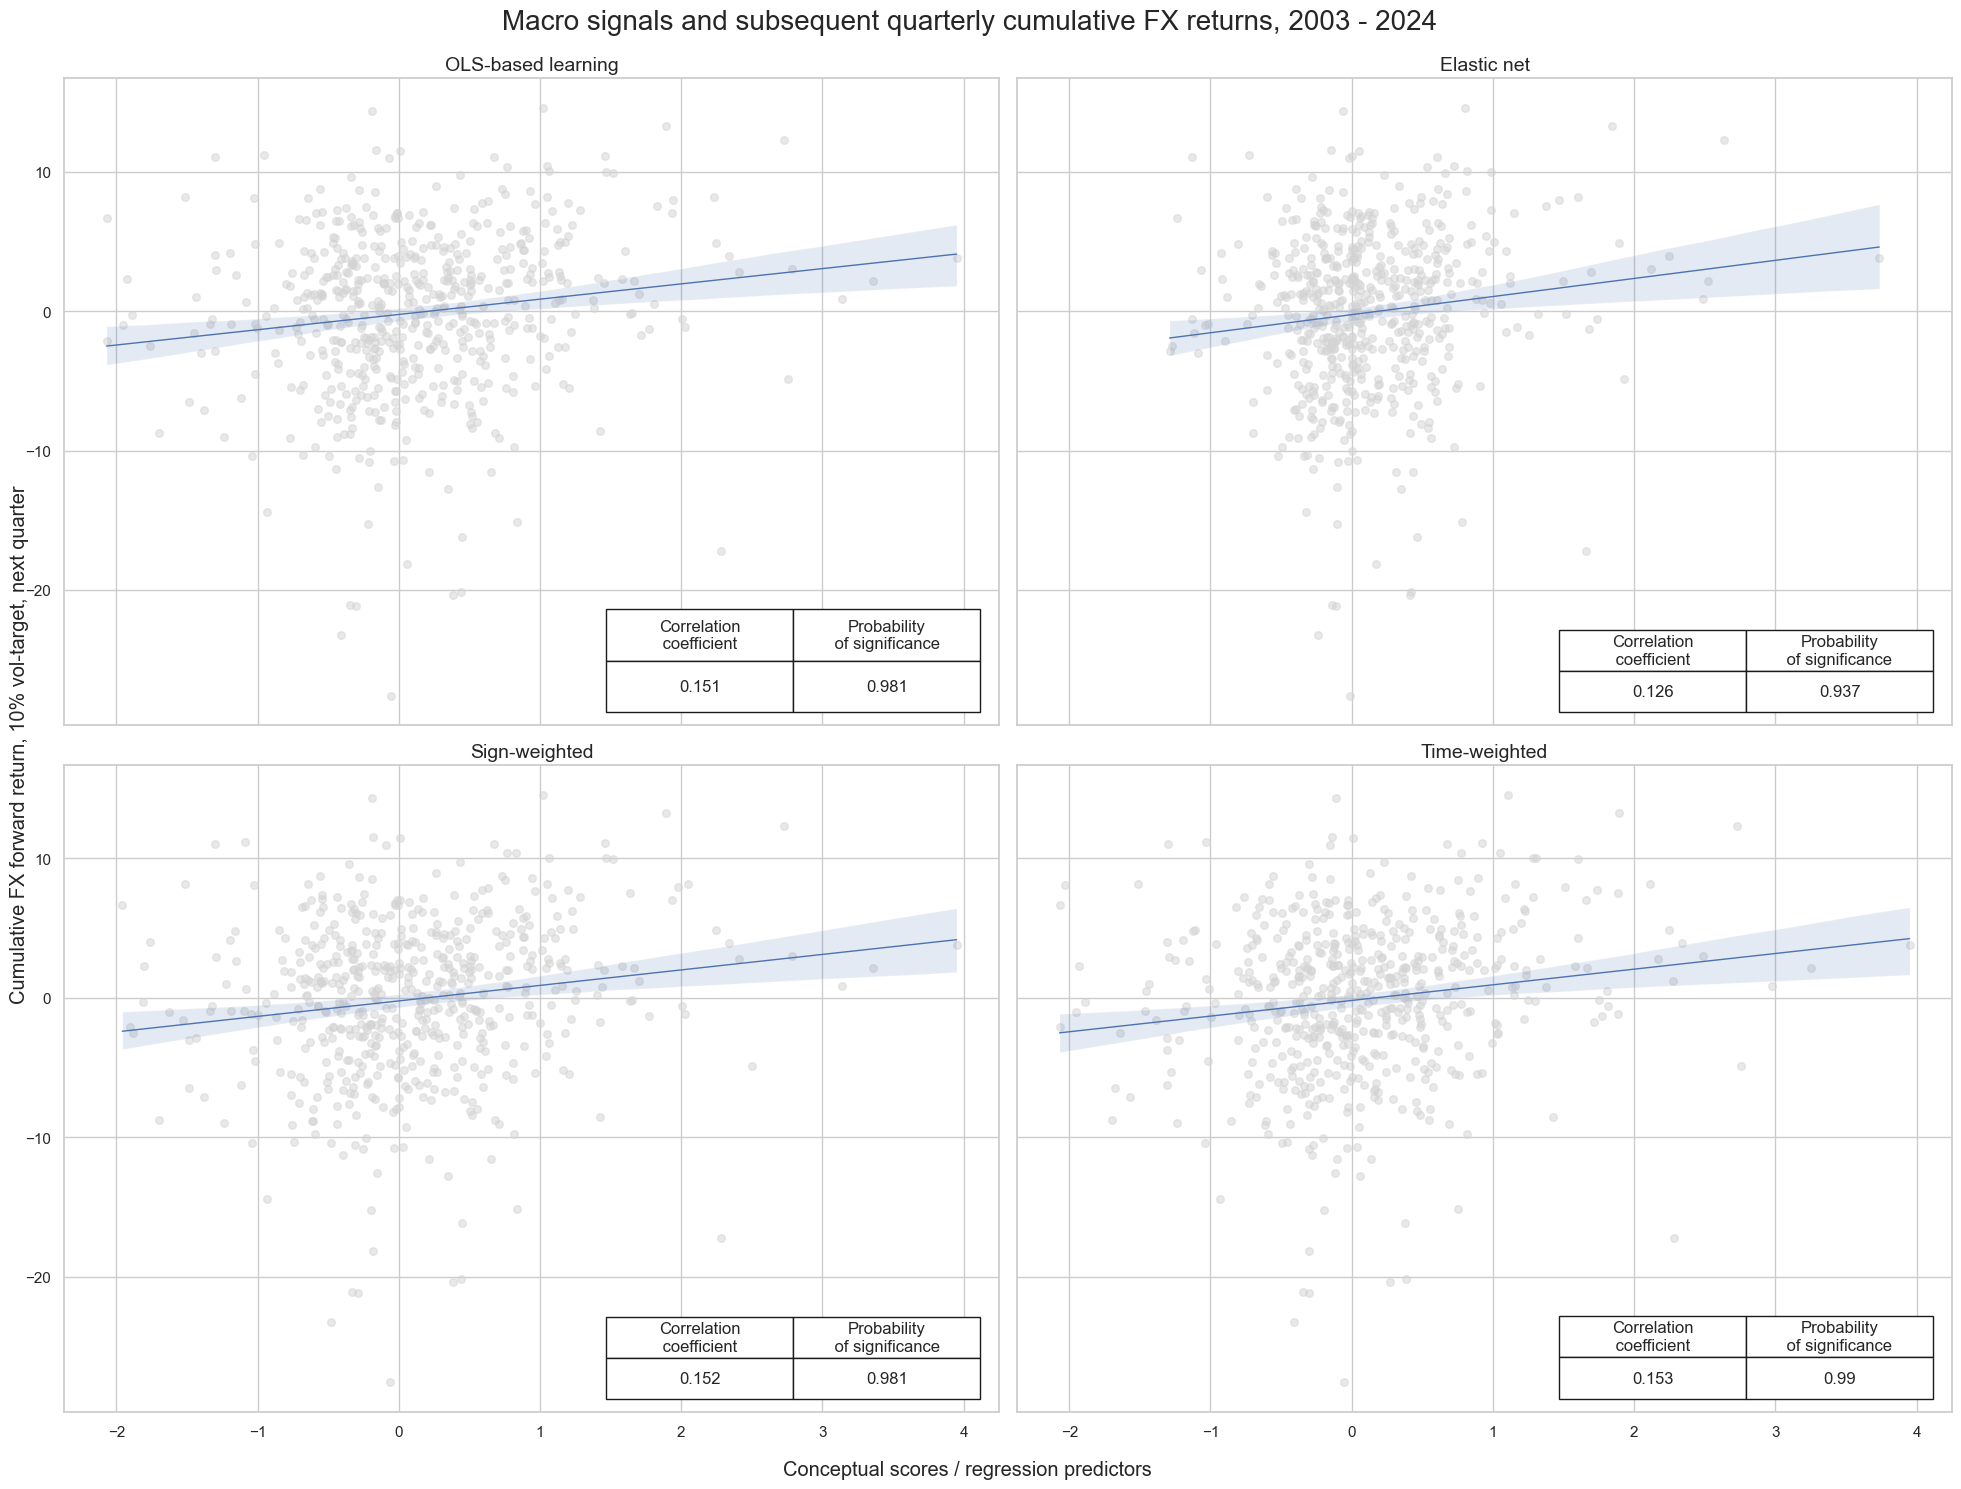

In [65]:
dix = dict_ams

sigx = dix["sigs"]
tarx = dix["targs"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]


def crmaker(sig, targ):
    crx = msp.CategoryRelations(
        dfx,
        xcats=[sig, targ],
        cids=cidx,
        freq="Q",
        lag=1,
        xcat_aggs=["last", "sum"],
        start=start,
        blacklist=blax,
    )
    return crx


lcrs = [crmaker(sig, targ) for sig in sigx[1:] for targ in tarx]

msv.multiple_reg_scatter(
    lcrs,
    ncol=2,
    nrow=2,
    title="Macro signals and subsequent quarterly cumulative FX returns, 2003 - 2024",
    xlab="Conceptual scores / regression predictors ",
    ylab="Cumulative FX forward return, 10% vol-target, next quarter",
    coef_box="lower right",
    prob_est="map",
    subplot_titles=["OLS-based learning", "Elastic net", "Sign-weighted", "Time-weighted"],
)

#### Accuracy and correlation check

The [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class of the [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package facilitates a quick assessment of the power of a signal category in predicting the direction of subsequent returns for data in JPMaQS format.

In [66]:
## Compare optimized signals

dix = dict_ams

sigx = dix["sigs"]
tarx = dix["targs"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    df=dfx,
    rets=tarx,
    sigs=sigx,
    cids=cids_dmfx,
    cosp=True,
    freqs=["M"],
    agg_sigs=["last"],
    start=start,
    blacklist=fxblack,
    slip=1,
    ms_panel_test=True,
)
dix["srr"] = srr

In [67]:
srr = dict_ams["srr"]

selcols = [
    "accuracy",
    "bal_accuracy",
    "pos_sigr",
    "pos_retr",
    "pearson",
    "map_pval",
    "kendall",
    "kendall_pval",
]
srr.multiple_relations_table().round(3)[selcols]

accuracy  bal_accuracy  pos_sigr  \
Return    Signal   Frequency Aggregation                                     
FXXR_VT10 ALL_AVGZ M         last            0.526         0.526     0.495   
          EN       M         last            0.537         0.537     0.548   
          LS       M         last            0.535         0.535     0.530   
          SW       M         last            0.541         0.541     0.520   
          TW       M         last            0.535         0.535     0.511   

                                          pos_retr  pearson  map_pval  \
Return    Signal   Frequency Aggregation                                
FXXR_VT10 ALL_AVGZ M         last            0.505    0.057     0.027   
          EN       M         last            0.504    0.076     0.095   
          LS       M         last            0.505    0.095     0.016   
          SW       M         last            0.505    0.093     0.022   
          TW       M         last            0.505    0.083     0.025   

                                          kendall  kendall_pval  
Return    Signal   Frequency Aggregation                         
FXXR_VT10 ALL_AVGZ M         last           0.044         0.006  
          EN       M         last           0.056         0.000  
          LS       M         last           0.070         0.000  
          SW       M         last           0.068         0.000  
          TW       M         last           0.062         0.000

#### Naive PnL

[`NaivePnl()` class](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) from [`macrosynergy`](https://github.com/macrosynergy/macrosynergy) package is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. 

The related `make_pnl()` method calculates and stores generic PnLs based on a range of signals and their transformations into positions. The positioning options include choice of trading frequency, z-scoring, simple equal-size long-short positions (-1/1) thresholds to prevent outsized positions, and rebalancing slippage.
The generated PnLs are, however, naive insofar as they do not consider trading costs and plausible risk management restrictions. Also, if a volatility scale is set this is done so ex-post, mainly for the benefit of plotting different signals'  PnLs in a single chart.

A complementary method is `make_long_pnl()`, which calculates a "long-only" PnL based on a uniform long position across all markets at all times. This often serves as a benchmark for gauging the benefits of active trading.

In [68]:
dix = dict_ams

sigx = dix["sigs"]
tarx = dix["targs"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

pnls = msn.NaivePnL(
    df=dfx,
    ret=tarx[0],
    sigs=sigx,
    cids=cidx,
    start=start,
    blacklist=fxblack,
    bms=["USD_GB10YXR_NSA", "EUR_FXXR_NSA", "USD_EQXR_NSA"],
)
for sig in sigx:
    pnls.make_pnl(
        sig=sig,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=10,
        thresh=3,
    )
pnls.make_long_pnl(vol_scale=10, label="Long only")

dix["pnls"] = pnls

The PnLs are plotted using `.plot_pnls()` method of the [`NaivePnl()` class](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl). These plots mainly inform on seasonality and stability of value generation under the assumption of negligible transaction costs. The post argues, that the underperformance of elastic net methods may not be accidental. Shrinkage-based regularization involves reducing model coefficients so that small changes in the input(s) lead to small changes in the predictions made. The idea is that introducing some bias into the regression can help reduce the variance in predictions made.  Whilst theoretically sound, this in practice leads to more frequent model changes, as the appropriate type and size of penalties must be estimated based on the scarce data. This accentuates a source of signal variation that is unrelated to macro trends. 

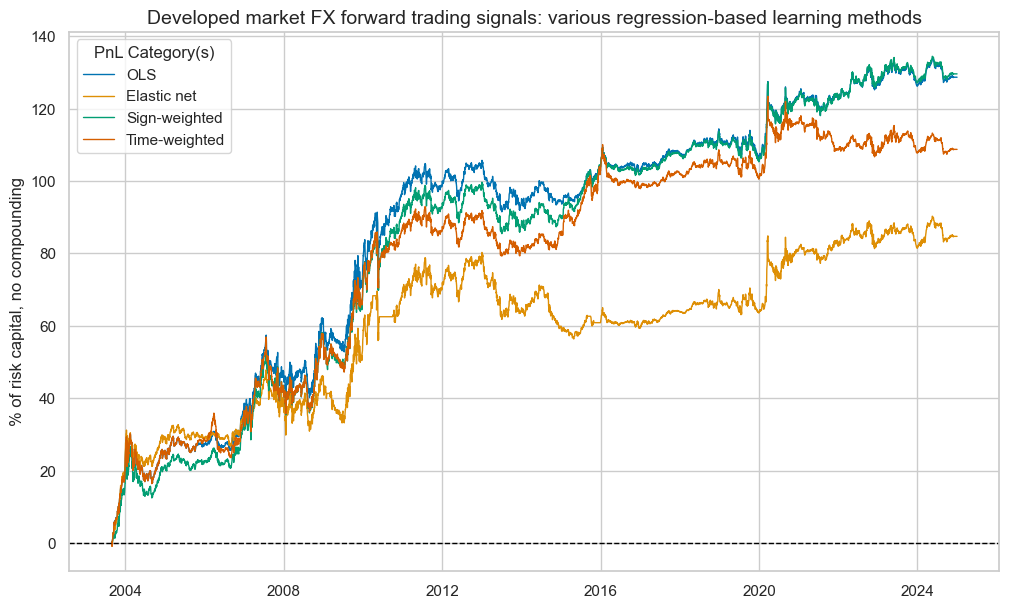

xcat                     PNL_ALL_AVGZ     PNL_LS     PNL_EN     PNL_SW  \
Return %                     5.211949   6.029726   3.971191   6.072858   
St. Dev. %                       10.0       10.0       10.0       10.0   
Sharpe Ratio                 0.521195   0.602973   0.397119   0.607286   
Sortino Ratio                0.735612   0.850947   0.555705   0.859513   
Max 21-Day Draw %          -14.843093 -15.191913 -12.361872  -15.25575   
Max 6-Month Draw %         -14.105099 -14.775656 -17.854891 -15.164625   
Peak to Trough Draw %      -30.795265 -17.724782 -23.882748  -18.18197   
Top 5% Monthly PnL Share     0.725327   0.579577   0.875488   0.572797   
USD_GB10YXR_NSA correl      -0.087311  -0.071956  -0.083888  -0.071809   
EUR_FXXR_NSA correl          0.124402   0.139716    0.17666   0.120693   
USD_EQXR_NSA correl          0.118615   0.030918   0.039827   0.024582   
Traded Months                     257        257        257        257   

xcat                         PNL_TW  Long only  
Return %                   5.096418  -0.433958  
St. Dev. %                     10.0       10.0  
Sharpe Ratio               0.509642  -0.043396  
Sortino Ratio              0.715337  -0.059703  
Max 21-Day Draw %        -15.228566 -23.133937  
Max 6-Month Draw %       -18.310398 -22.868546  
Peak to Trough Draw %    -21.200599 -72.266181  
Top 5% Monthly PnL Share   0.711704  -8.061563  
USD_GB10YXR_NSA correl    -0.056761  -0.012885  
EUR_FXXR_NSA correl         0.12351   0.409875  
USD_EQXR_NSA correl         0.01232   0.245412  
Traded Months                   257        257

In [69]:
dix = dict_ams

pnls = dix["pnls"]
sigx = dix["sigs"]

pnls.plot_pnls(
    pnl_cats=["PNL_" + sig for sig in sigx[1:]],
    title="Developed market FX forward trading signals: various regression-based learning methods",
    title_fontsize=14,
    xcat_labels=["OLS", "Elastic net", "Sign-weighted", "Time-weighted"],
)
pnls.evaluate_pnls(pnl_cats=["PNL_" + sig for sig in sigx] + ["Long only"])

## Correcting linear models for statistical precision

A notable issue with using regression-based learning as the sole component of a macro trading signal is that macroeconomic trends take time to form, meaning that model coefficients (and predictions) exhibit greater variability in early years, before the correlations have stabilised. As a consequence, absolute model coefficients have a tendency to decrease over time, producing smaller signals. This is exaggerated by the `NaivePnL` calculation because the signal considered by the PnL is a windorized z-score with standard deviation updated over time. 

One way of mitigating this is by adjusting linear model coefficients by their estimated standard errors. The resulting factor model has coefficients that take into account statistical precision of the parameter estimates based on sample size. 

### OLS/NNLS: analytical standard error adjustment

In [70]:
# Specify model options and grids

mods_mls = {
    "mls": msl.ModifiedLinearRegression(method="analytic", error_offset=1e-5),
}

grid_mls = {
    "mls": {"positive": [True, False], "fit_intercept": [True, False]},
}

In [71]:
xcatx = cpoz + ["FXXR_VT10"]
cidx = cids_dmfx

so_mls = msl.SignalOptimizer(
    df = dfx,
    xcats = xcatx,
    cids = cidx,
    blacklist = fxblack,
    freq = "M",
    lag = 1,
    xcat_aggs = ["last", "sum"]
)

In [72]:
so_mls.calculate_predictions(
    name = "MLS_analytic",
    models = mods_mls,
    hyperparameters = grid_mls,
    scorers = {"r2": scorer},
    inner_splitters = {"Rolling": splitter},
    search_type = "grid",
    normalize_fold_results = False,
    cv_summary = "mean",
    min_cids = 2,
    min_periods = 36,
    test_size = 1,
    n_jobs_outer = -1,
    split_functions={"Rolling": lambda n: n // 36},
)

dfa = so_mls.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/256 [00:00<?, ?it/s]

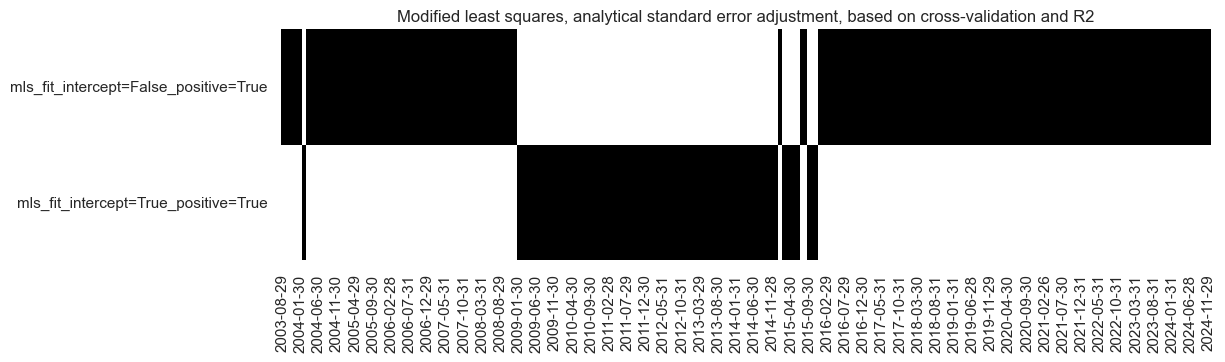

In [73]:
# Illustrate model choice

so_mls.models_heatmap(
    "MLS_analytic",
    title="Modified least squares, analytical standard error adjustment, based on cross-validation and R2",
    figsize=(12, 3),
)

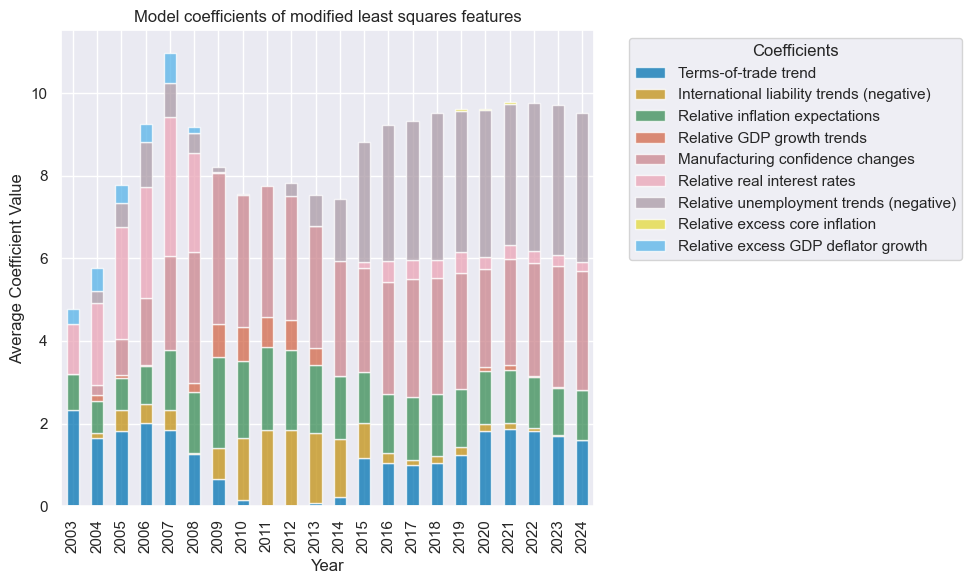

In [74]:
so_mls.coefs_stackedbarplot("MLS_analytic", title="Model coefficients of modified least squares features", ftrs_renamed=ftrs_dict)

### OLS/NNLS: White's estimator for standard errors

The usual standard error expressions are subject to assumptions that are violated - particularly the assumption of constant error variance. White's estimator is a standard error estimator that takes into account heteroskedasticity. We implement the HC3 version of this estimator. 

In [75]:
# Specify model options and grids

mods_mls = {
    "mls": msl.ModifiedLinearRegression(method="analytic", analytic_method="White", error_offset=1e-5),
}

grid_mls = {
    "mls": {"positive": [True, False], "fit_intercept": [True, False]},
}

In [76]:
so_mls.calculate_predictions(
    name = "MLS_white",
    models = mods_mls,
    hyperparameters = grid_mls,
    scorers = {"r2": scorer},
    inner_splitters = {"Rolling": splitter},
    search_type = "grid",
    normalize_fold_results = False,
    cv_summary = "mean",
    min_cids = 2,
    min_periods = 36,
    test_size = 1,
    n_jobs_outer = -1,
    split_functions={"Rolling": lambda n: n // 36},
)

dfa = so_mls.get_optimized_signals(name="MLS_white")
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/256 [00:00<?, ?it/s]

### OLS/NNLS: panel bootstrap standard error adjustment

In [81]:
# Specify model options and grids

mods_mls = {
    "mls": msl.ModifiedLinearRegression(method="bootstrap",bootstrap_iters=100, error_offset=1e-5),
}

grid_mls = {
    "mls": {"positive": [True, False], "fit_intercept": [True, False]},
}

In [82]:
so_mls.calculate_predictions(
    name = "MLS_bootstrap",
    models = mods_mls,
    hyperparameters = grid_mls,
    scorers = {"r2": scorer},
    inner_splitters = {"Rolling": splitter},
    search_type = "grid",
    normalize_fold_results = False,
    cv_summary = "mean",
    min_cids = 2,
    min_periods = 36,
    test_size = 1,
    n_jobs_outer = -1,
    split_functions={"Rolling": lambda n: n // 36},
)

dfa = so_mls.get_optimized_signals(name="MLS_bootstrap")
dfx = msm.update_df(dfx, dfa)

  0%|          | 0/255 [00:00<?, ?it/s]

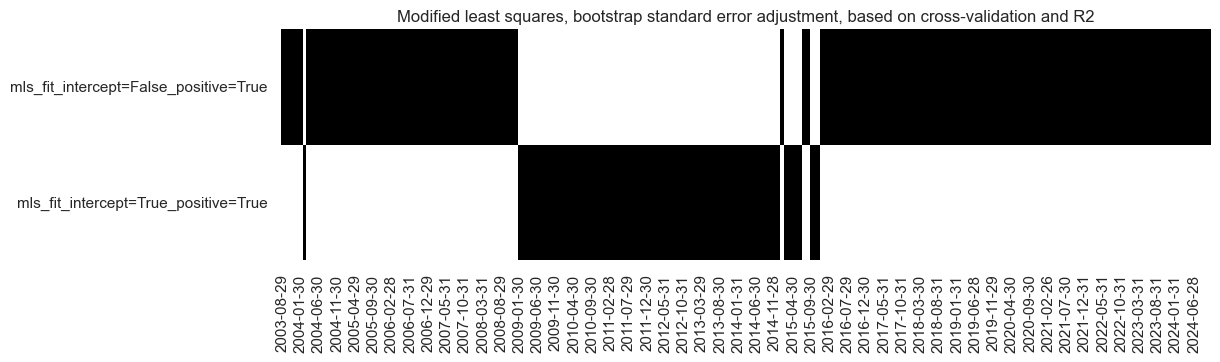

In [83]:
# Illustrate model choice

so_mls.models_heatmap(
    "MLS_bootstrap",
    title="Modified least squares, bootstrap standard error adjustment, based on cross-validation and R2",
    figsize=(12, 3),
)

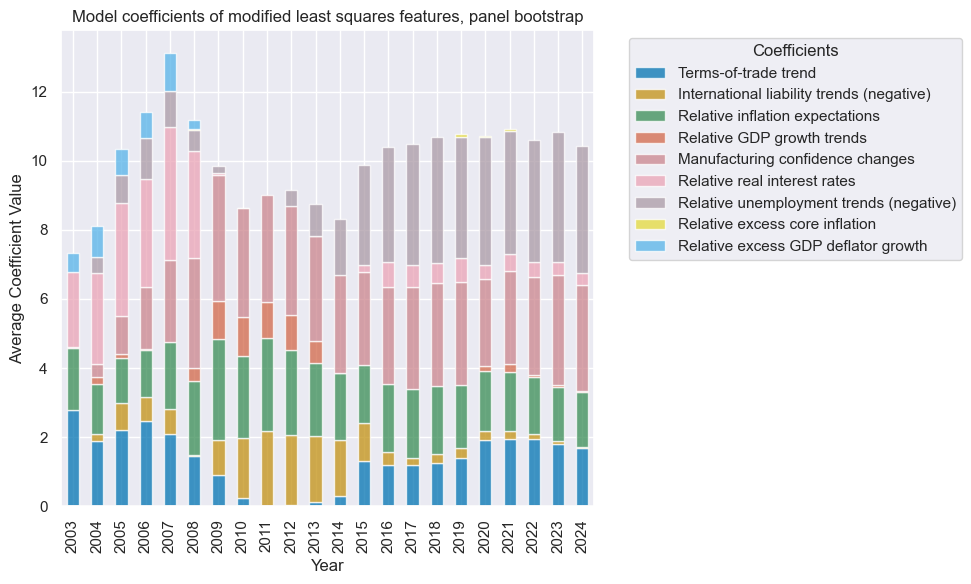

In [84]:
so_mls.coefs_stackedbarplot("MLS_bootstrap", title="Model coefficients of modified least squares features, panel bootstrap", ftrs_renamed=ftrs_dict)

### Comparison

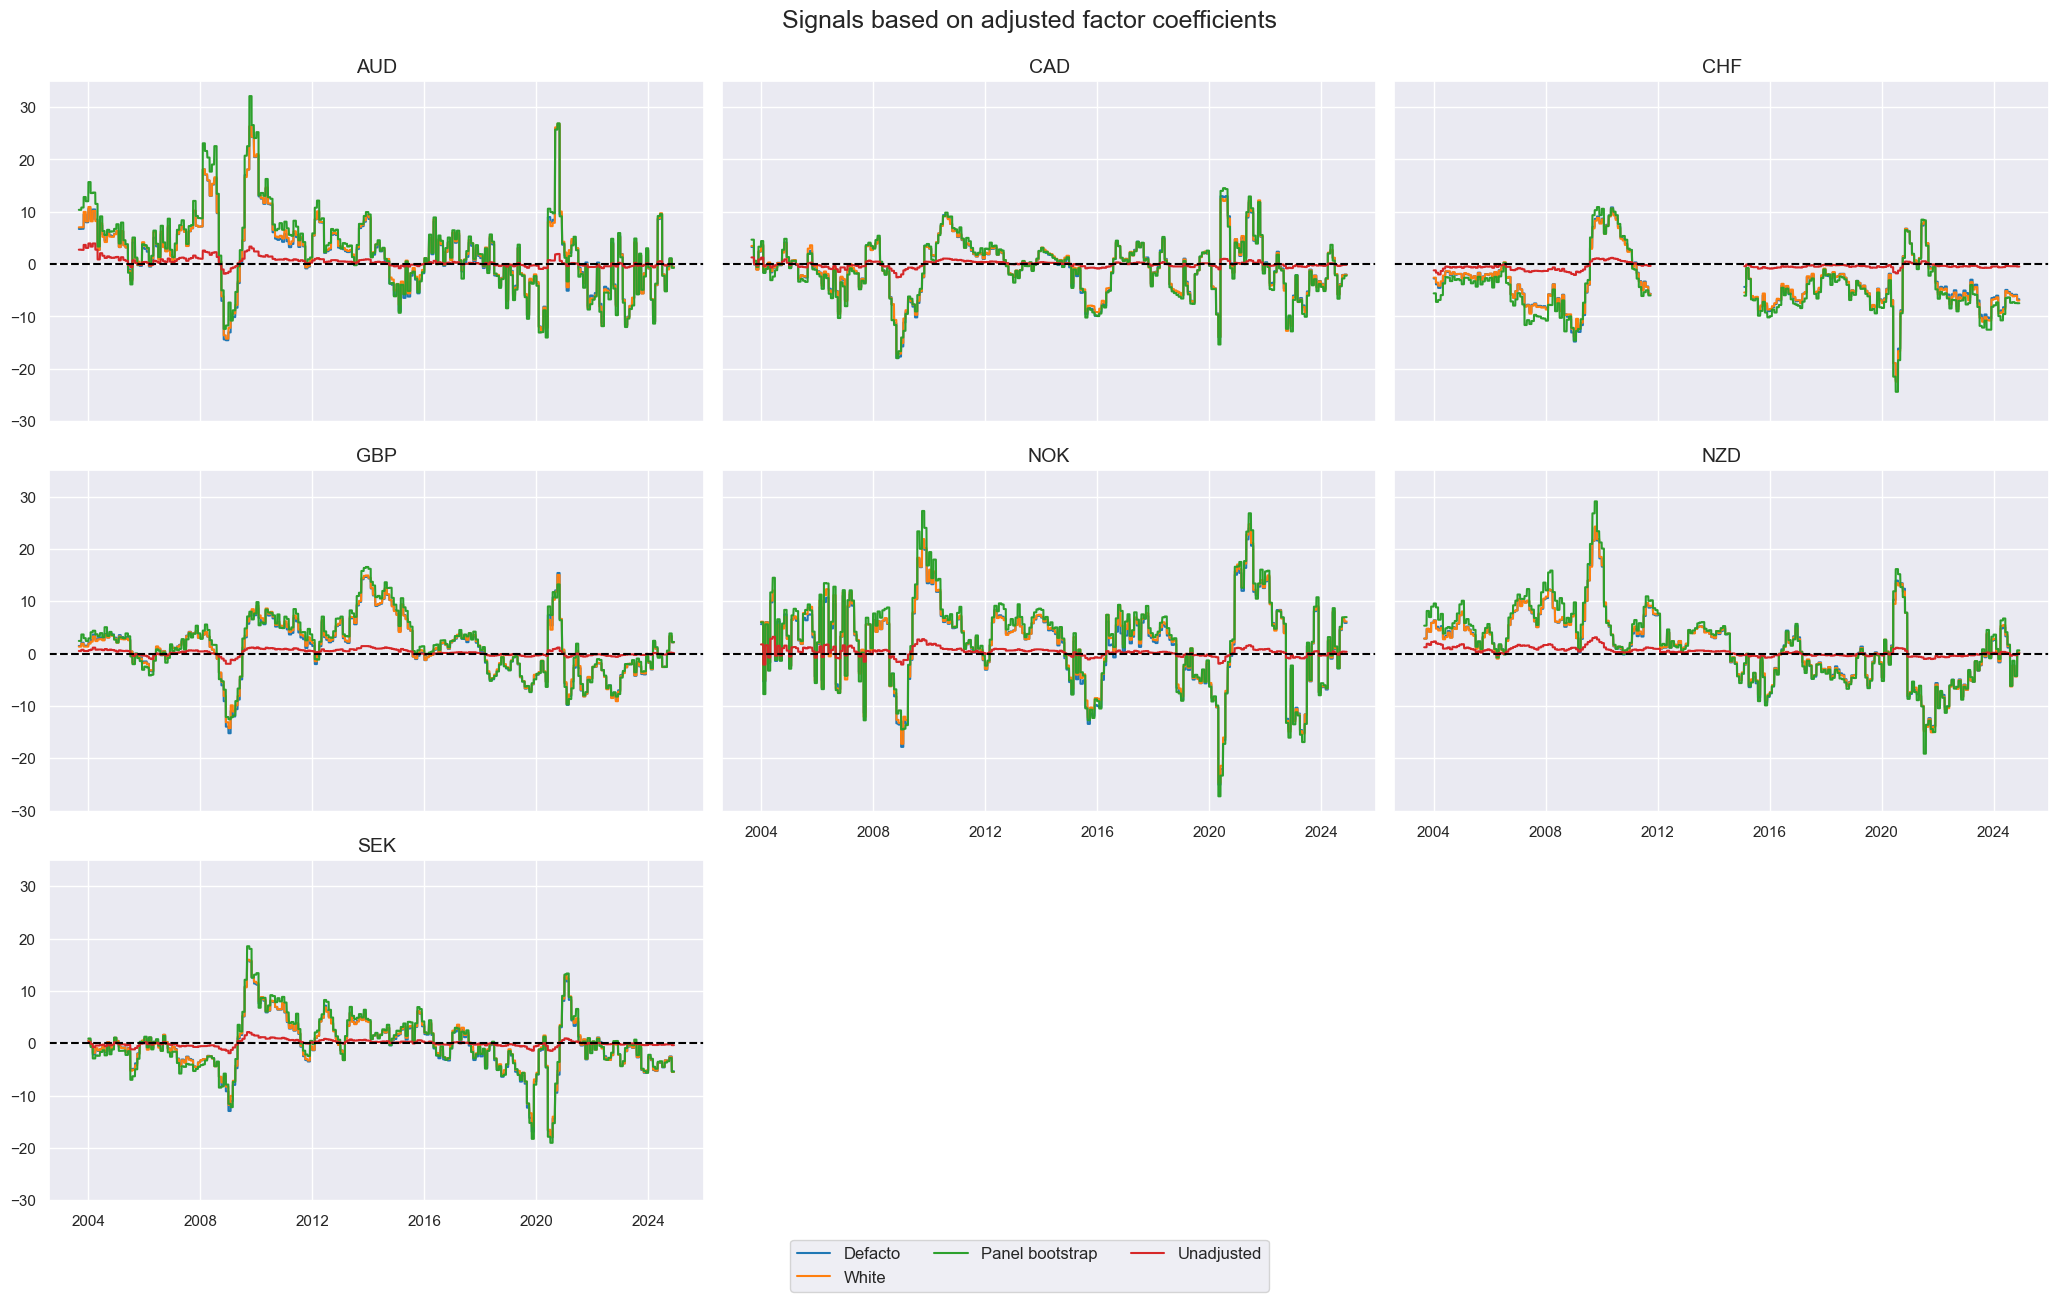

In [85]:
xcatx = [
    "MLS_analytic",
    "MLS_white",
    "MLS_bootstrap",
    "LS"
]
cidx = cids_dmfx

msp.view_timelines(
    df = dfx,
    xcats = xcatx,
    cids = cidx,
    title="Signals based on adjusted factor coefficients",
    xcat_labels=["Defacto", "White", "Panel bootstrap", "Unadjusted"]
)

By adjusting the coefficients, the value generated in the early history is mitigated - as hoped - resulting in more consistent PnL generation over the 20 years. A consequence of adjusting by statistical precision is that one is able to take greater advantage of more recent periods where there is a clear long/short signal, instead of the signal petering out over time. 

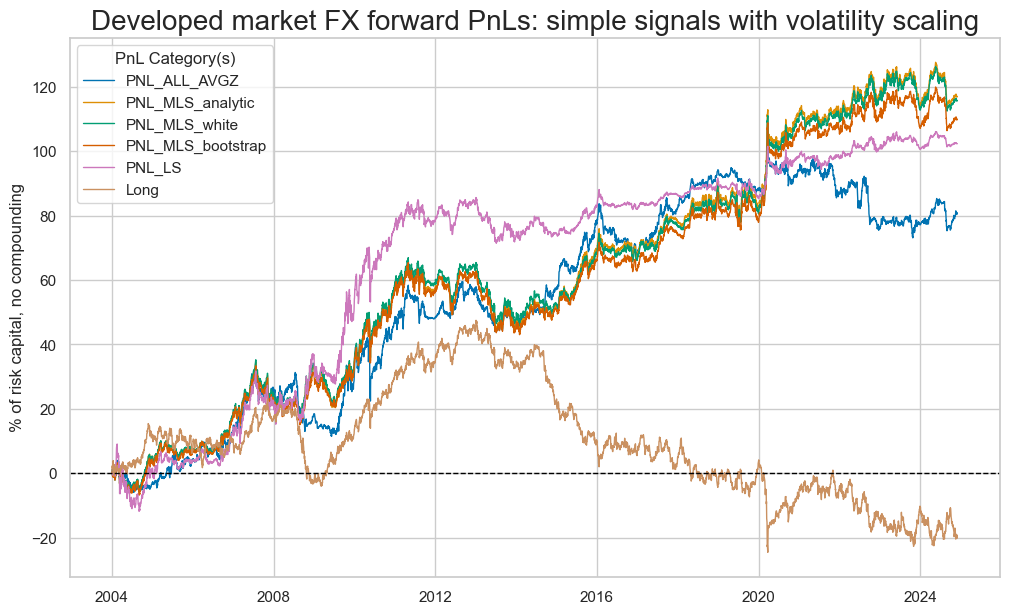

xcat                           Long PNL_ALL_AVGZ PNL_MLS_analytic  \
Return %                   -0.92455     3.864559         5.595817   
St. Dev. %                     10.0         10.0             10.0   
Sharpe Ratio              -0.092455     0.386456         0.559582   
Sortino Ratio             -0.126782      0.53985         0.787278   
Max 21-Day Draw %        -23.065732   -19.618452       -13.822903   
Max 6-Month Draw %       -22.801123   -14.746112       -18.166749   
Peak to Trough Draw %    -72.053121   -30.033006       -21.351394   
Top 5% Monthly PnL Share  -3.836347      0.97085         0.664541   
USD_GB10YXR_NSA correl    -0.013323    -0.091145        -0.077103   
EUR_FXXR_NSA correl        0.409057     0.136722         0.060172   
USD_EQXR_NSA correl        0.248706     0.124388        -0.003433   
Traded Months                   251          251              251   

xcat                     PNL_MLS_white PNL_MLS_bootstrap     PNL_LS  
Return %                      5.535685           5.25837   4.895306  
St. Dev. %                        10.0              10.0       10.0  
Sharpe Ratio                  0.553569          0.525837   0.489531  
Sortino Ratio                 0.778566          0.737231   0.681116  
Max 21-Day Draw %           -13.888335         -13.41565 -16.766195  
Max 6-Month Draw %          -18.506355         -18.51456 -17.025071  
Peak to Trough Draw %       -21.114831        -22.354549 -20.880637  
Top 5% Monthly PnL Share      0.665043          0.696498   0.717804  
USD_GB10YXR_NSA correl       -0.081348         -0.083263   -0.06613  
EUR_FXXR_NSA correl           0.066599          0.074526   0.149307  
USD_EQXR_NSA correl            0.00293          0.012423   0.053996  
Traded Months                      251               251        251

In [86]:
sigx = [
    "ALL_AVGZ",
    "MLS_analytic",
    "MLS_white",
    "MLS_bootstrap",
    "LS",
]

pnl = msn.NaivePnL(
    df = dfx,
    ret = "FXXR_VT10",
    cids=cids_dmfx,
    sigs = sigx,
    blacklist=fxblack,
    start="2004-01-01",
    bms=["USD_GB10YXR_NSA", "EUR_FXXR_NSA", "USD_EQXR_NSA"],
)

pnl.make_long_pnl(vol_scale=10,label="Long")
for sig in sigx:
    pnl.make_pnl(
        sig = sig,
        sig_op="raw",
        rebal_freq="monthly",
        rebal_slip=1,
        vol_scale=10,
        thresh=5
    )

pnames = ["PNL_" + sig for sig in sigx] + ["Long"]
pnl.plot_pnls(
    pnl_cats=pnames,
    title="Developed market FX forward PnLs: simple signals with volatility scaling",
)
pnl.evaluate_pnls(pnl_cats=pnames)

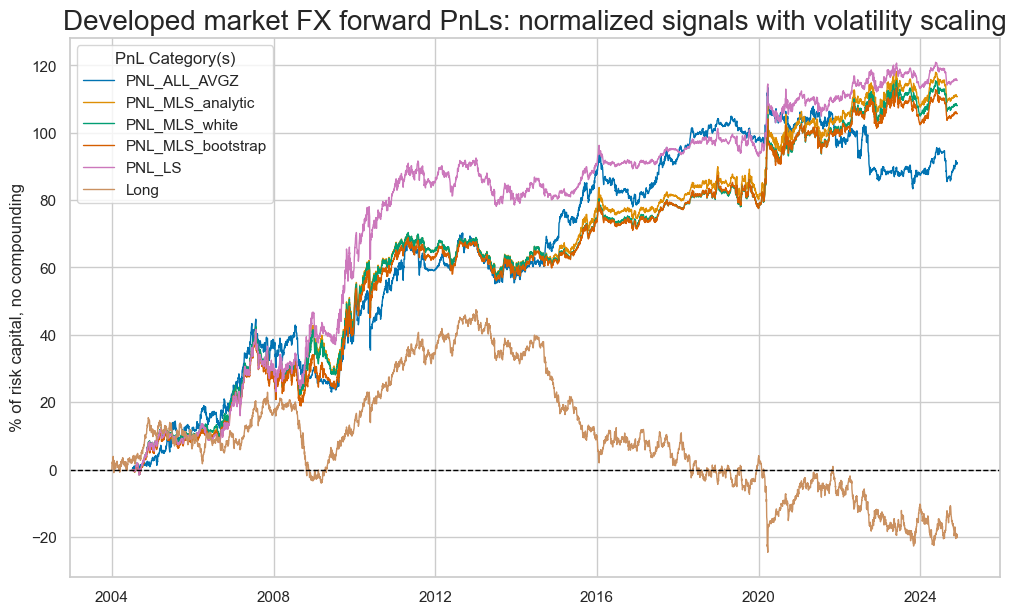

xcat                           Long PNL_ALL_AVGZ PNL_MLS_analytic  \
Return %                   -0.92455      4.46374         5.430595   
St. Dev. %                     10.0         10.0             10.0   
Sharpe Ratio              -0.092455     0.446374         0.543059   
Sortino Ratio             -0.126782      0.63411         0.778092   
Max 21-Day Draw %        -23.065732   -17.656563       -13.688723   
Max 6-Month Draw %       -22.801123   -14.699633       -16.764413   
Peak to Trough Draw %    -72.053121   -30.089127       -20.009813   
Top 5% Monthly PnL Share  -3.836347     0.848994          0.66864   
USD_GB10YXR_NSA correl    -0.013323    -0.095306        -0.075816   
EUR_FXXR_NSA correl        0.409057     0.128249         0.057387   
USD_EQXR_NSA correl        0.248706     0.122349        -0.013755   
Traded Months                   251          251              251   

xcat                     PNL_MLS_white PNL_MLS_bootstrap     PNL_LS  
Return %                      5.300886          5.183684   5.666545  
St. Dev. %                        10.0              10.0       10.0  
Sharpe Ratio                  0.530089          0.518368   0.566654  
Sortino Ratio                  0.75818          0.740538   0.810898  
Max 21-Day Draw %           -14.043633        -13.782562 -15.397057  
Max 6-Month Draw %           -16.98785        -16.227148 -15.456484  
Peak to Trough Draw %       -20.206334        -21.311656 -18.527638  
Top 5% Monthly PnL Share      0.672063          0.670756   0.646396  
USD_GB10YXR_NSA correl       -0.083268         -0.092189  -0.088641  
EUR_FXXR_NSA correl           0.066144          0.088598   0.105078  
USD_EQXR_NSA correl          -0.003922          0.018741   0.032487  
Traded Months                      251               251        251

In [87]:
sigx = [
    "ALL_AVGZ",
    "MLS_analytic",
    "MLS_white",
    "MLS_bootstrap",
    "LS",
]

pnl = msn.NaivePnL(
    df = dfx,
    ret = "FXXR_VT10",
    cids=cids_dmfx,
    sigs = sigx,
    blacklist=fxblack,
    start="2004-01-01",
    bms=["USD_GB10YXR_NSA", "EUR_FXXR_NSA", "USD_EQXR_NSA"],
)

pnl.make_long_pnl(vol_scale=10,label="Long")
for sig in sigx:
    pnl.make_pnl(
        sig = sig,
        sig_op="zn_score_pan",
        min_obs=22 * 6,  # minimum required data for normalization
        iis=False,  # allow no in-sample bias
        rebal_freq="monthly",
        rebal_slip=1,
        vol_scale=10,
        thresh=4
    )

pnames = ["PNL_" + sig for sig in sigx] + ["Long"]
pnl.plot_pnls(
    pnl_cats=pnames,
    title="Developed market FX forward PnLs: normalized signals with volatility scaling",
)
pnl.evaluate_pnls(pnl_cats=pnames)

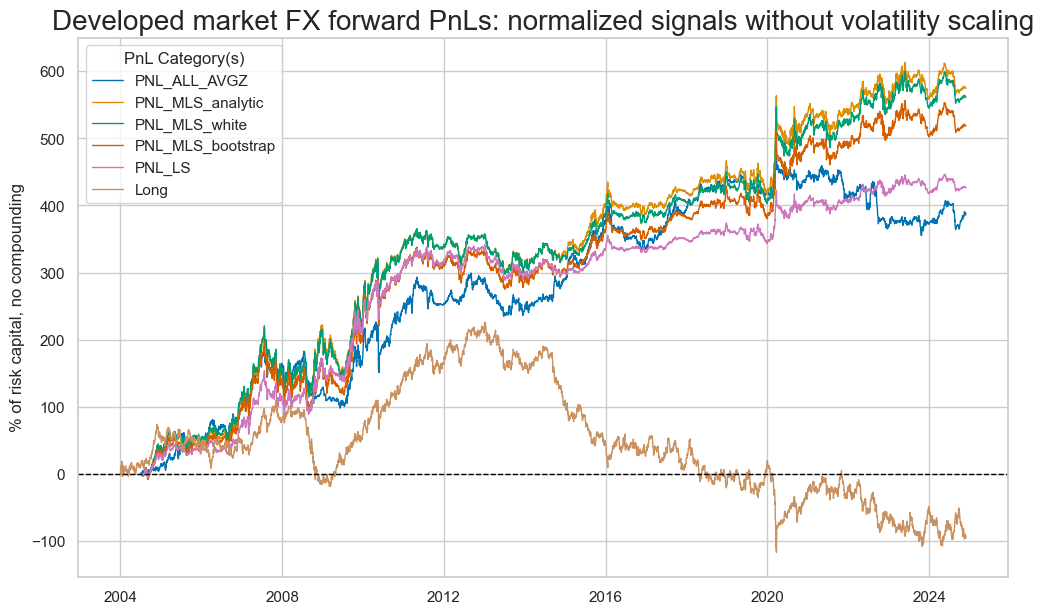

xcat                            Long PNL_ALL_AVGZ PNL_MLS_analytic  \
Return %                   -4.403992    19.007053        28.184664   
St. Dev. %                 47.633919    42.581008        51.899774   
Sharpe Ratio               -0.092455     0.446374         0.543059   
Sortino Ratio              -0.126782      0.63411         0.778092   
Max 21-Day Draw %        -109.871121   -75.183425       -71.044161   
Max 6-Month Draw %       -108.610685   -62.592519       -87.006926   
Peak to Trough Draw %     -343.21725  -128.122537      -103.850474   
Top 5% Monthly PnL Share   -3.836347     0.848994          0.66864   
USD_GB10YXR_NSA correl     -0.013323    -0.095306        -0.075816   
EUR_FXXR_NSA correl         0.409057     0.128249         0.057387   
USD_EQXR_NSA correl         0.248706     0.122349        -0.013755   
Traded Months                    251          251              251   

xcat                     PNL_MLS_white PNL_MLS_bootstrap     PNL_LS  
Return %                     27.519177          25.42674  20.916911  
St. Dev. %                   51.914301         49.051481  36.912991  
Sharpe Ratio                  0.530089          0.518368   0.566654  
Sortino Ratio                  0.75818          0.740538   0.810898  
Max 21-Day Draw %           -72.906542        -67.605505 -56.835144  
Max 6-Month Draw %          -88.191237        -79.596562 -57.054505  
Peak to Trough Draw %      -104.899769       -104.536827 -68.391055  
Top 5% Monthly PnL Share      0.672063          0.670756   0.646396  
USD_GB10YXR_NSA correl       -0.083268         -0.092189  -0.088641  
EUR_FXXR_NSA correl           0.066144          0.088598   0.105078  
USD_EQXR_NSA correl          -0.003922          0.018741   0.032487  
Traded Months                      251               251        251

In [88]:
sigx = [
    "ALL_AVGZ",
    "MLS_analytic",
    "MLS_white",
    "MLS_bootstrap",
    "LS",
]

pnl = msn.NaivePnL(
    df = dfx,
    ret = "FXXR_VT10",
    cids=cids_dmfx,
    sigs = sigx,
    blacklist=fxblack,
    start="2004-01-01",
    bms=["USD_GB10YXR_NSA", "EUR_FXXR_NSA", "USD_EQXR_NSA"],
)

pnl.make_long_pnl(label="Long")
for sig in sigx:
    pnl.make_pnl(
        sig = sig,
        sig_op="zn_score_pan",
        min_obs=22 * 6,  # minimum required data for normalization
        iis=False,  # allow no in-sample bias
        rebal_freq="monthly",
        rebal_slip=1,
        thresh=4
    )

pnames = ["PNL_" + sig for sig in sigx] + ["Long"]
pnl.plot_pnls(
    pnl_cats=pnames,
    title="Developed market FX forward PnLs: normalized signals without volatility scaling",
)
pnl.evaluate_pnls(pnl_cats=pnames)

The coefficients for the unadjusted OLS-based signal noticeably diminished post-2010. A comparison between the adjusted and unadjusted OLS signals in this period revealed substantial outperformance of the adjusted signal in this period. 

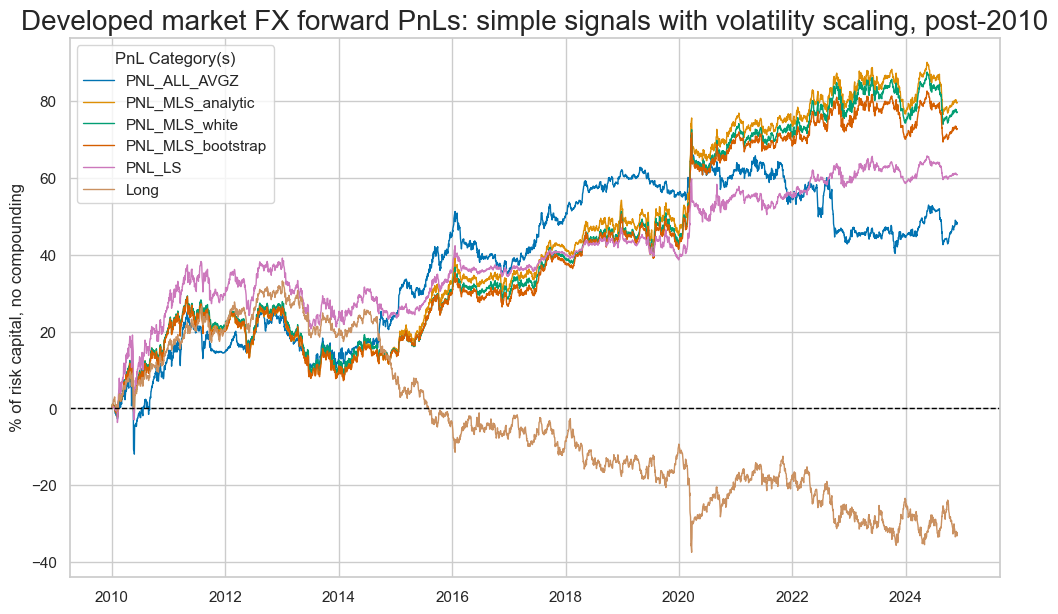

xcat                           Long PNL_ALL_AVGZ PNL_MLS_analytic  \
Return %                   -2.16832     3.240884         5.345692   
St. Dev. %                     10.0         10.0             10.0   
Sharpe Ratio              -0.216832     0.324088         0.534569   
Sortino Ratio             -0.294356     0.448844         0.759138   
Max 21-Day Draw %        -22.621368   -20.229224       -13.596687   
Max 6-Month Draw %       -19.717585    -14.10706       -17.869444   
Peak to Trough Draw %    -70.665007   -30.968011       -21.001971   
Top 5% Monthly PnL Share  -1.622954     1.217846         0.710515   
USD_GB10YXR_NSA correl     0.015664    -0.075037        -0.114884   
EUR_FXXR_NSA correl        0.326556     0.123358         0.011575   
USD_EQXR_NSA correl        0.296793     0.127985        -0.007362   
Traded Months                   179          179              179   

xcat                     PNL_MLS_white PNL_MLS_bootstrap     PNL_LS  
Return %                      5.178884          4.887603   4.084634  
St. Dev. %                        10.0              10.0       10.0  
Sharpe Ratio                  0.517888           0.48876   0.408463  
Sortino Ratio                 0.734478           0.69064    0.56178  
Max 21-Day Draw %           -13.630355        -13.158314 -21.787402  
Max 6-Month Draw %          -18.162593        -18.159418 -17.801421  
Peak to Trough Draw %       -20.722616        -21.925749 -22.100723  
Top 5% Monthly PnL Share      0.724512          0.769286    0.93927  
USD_GB10YXR_NSA correl       -0.119936         -0.120414  -0.113668  
EUR_FXXR_NSA correl           0.021055          0.031531   0.096827  
USD_EQXR_NSA correl           0.001926          0.011431   0.060877  
Traded Months                      179               179        179

In [89]:
sigx = [
    "ALL_AVGZ",
    "MLS_analytic",
    "MLS_white",
    "MLS_bootstrap",
    "LS",
]

pnl = msn.NaivePnL(
    df = dfx,
    ret = "FXXR_VT10",
    cids=cids_dmfx,
    sigs = sigx,
    blacklist=fxblack,
    start="2010-01-01",
    bms=["USD_GB10YXR_NSA", "EUR_FXXR_NSA", "USD_EQXR_NSA"],
)

pnl.make_long_pnl(vol_scale=10,label="Long")
for sig in sigx:
    pnl.make_pnl(
        sig = sig,
        sig_op="raw",
        rebal_freq="monthly",
        rebal_slip=1,
        vol_scale=10,
        thresh=5
    )

pnames = ["PNL_" + sig for sig in sigx] + ["Long"]
pnl.plot_pnls(
    pnl_cats=pnames,
    title="Developed market FX forward PnLs: simple signals with volatility scaling, post-2010",
)
pnl.evaluate_pnls(pnl_cats=pnames)

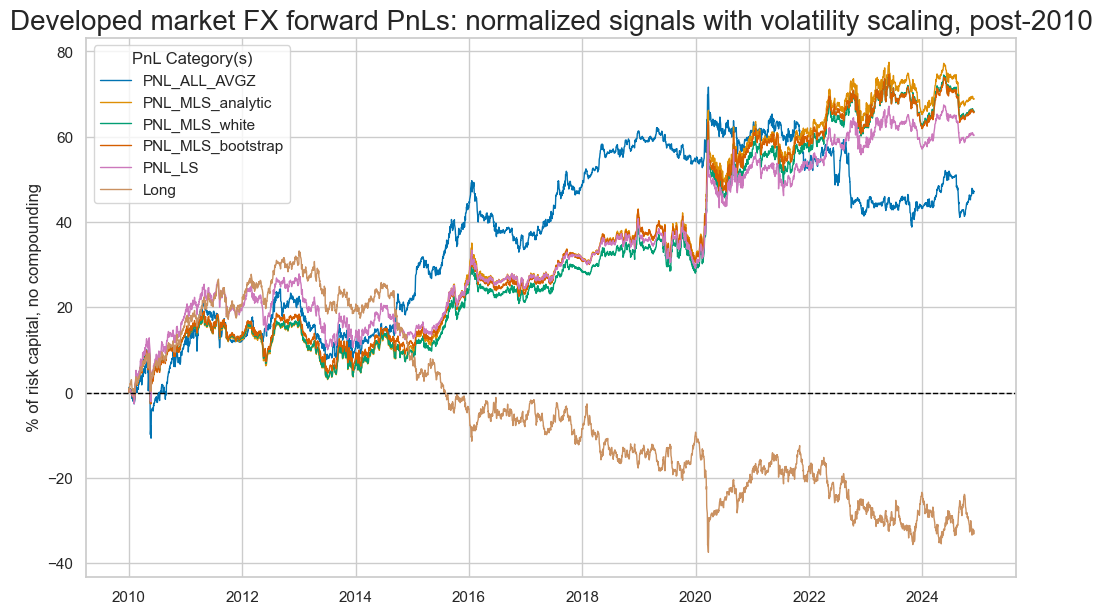

xcat                           Long PNL_ALL_AVGZ PNL_MLS_analytic  \
Return %                   -2.16832     3.161544         4.621014   
St. Dev. %                     10.0         10.0             10.0   
Sharpe Ratio              -0.216832     0.316154         0.462101   
Sortino Ratio             -0.294356     0.440384         0.661945   
Max 21-Day Draw %        -22.621368   -17.846605       -12.010833   
Max 6-Month Draw %       -19.717585   -14.614635       -13.385832   
Peak to Trough Draw %    -70.665007    -32.82331        -17.37586   
Top 5% Monthly PnL Share  -1.622954     1.257381         0.824436   
USD_GB10YXR_NSA correl     0.015664    -0.072937        -0.101714   
EUR_FXXR_NSA correl        0.326556     0.113491          0.00091   
USD_EQXR_NSA correl        0.296793     0.120792         -0.04605   
Traded Months                   179          179              179   

xcat                     PNL_MLS_white PNL_MLS_bootstrap     PNL_LS  
Return %                      4.425778           4.41232   4.050096  
St. Dev. %                        10.0              10.0       10.0  
Sharpe Ratio                  0.442578          0.441232    0.40501  
Sortino Ratio                 0.632144          0.627057   0.569836  
Max 21-Day Draw %           -12.137633        -12.445161 -14.773203  
Max 6-Month Draw %          -13.540575        -13.368312 -17.151638  
Peak to Trough Draw %       -17.347939        -16.695269 -17.784512  
Top 5% Monthly PnL Share       0.83956          0.864626   0.888809  
USD_GB10YXR_NSA correl       -0.108693         -0.108015  -0.111363  
EUR_FXXR_NSA correl           0.004608          0.020234   0.052105  
USD_EQXR_NSA correl          -0.037737         -0.020693   0.002524  
Traded Months                      179               179        179

In [90]:
sigx = [
    "ALL_AVGZ",
    "MLS_analytic",
    "MLS_white",
    "MLS_bootstrap",
    "LS",
]

pnl = msn.NaivePnL(
    df = dfx,
    ret = "FXXR_VT10",
    cids=cids_dmfx,
    sigs = sigx,
    blacklist=fxblack,
    start="2010-01-01",
    bms=["USD_GB10YXR_NSA", "EUR_FXXR_NSA", "USD_EQXR_NSA"],
)

pnl.make_long_pnl(vol_scale=10,label="Long")
for sig in sigx:
    pnl.make_pnl(
        sig = sig,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        rebal_slip=1,
        vol_scale=10,
        thresh=4
    )

pnames = ["PNL_" + sig for sig in sigx] + ["Long"]
pnl.plot_pnls(
    pnl_cats=pnames,
    title="Developed market FX forward PnLs: normalized signals with volatility scaling, post-2010",
)
pnl.evaluate_pnls(pnl_cats=pnames)

We see below that the signals from the unadjusted models vanished over time, whilst the adjusted versions are able to produce strong signals in the more recent past.

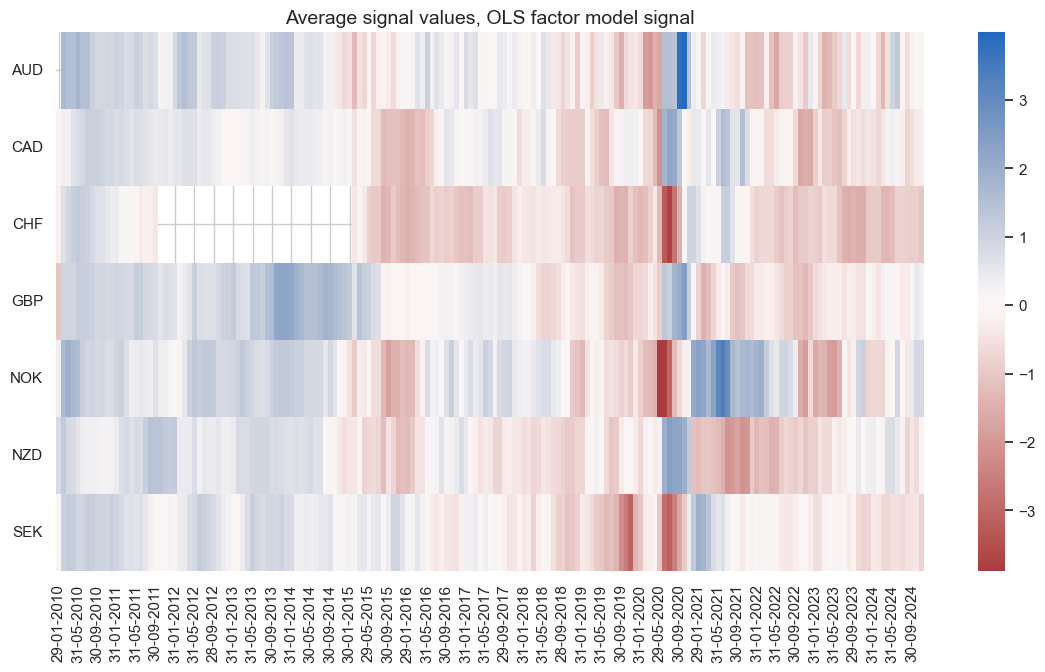

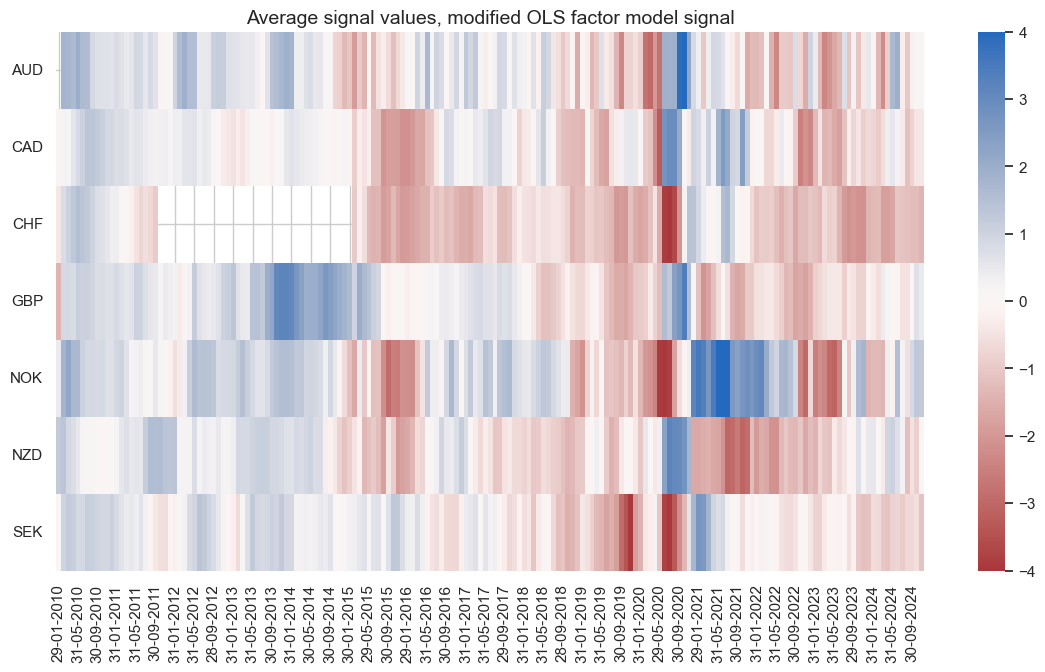

In [91]:
pnl.signal_heatmap(
    pnl_name="PNL_LS",
    title="Average signal values, OLS factor model signal"
)
pnl.signal_heatmap(
    pnl_name="PNL_MLS_analytic",
    title="Average signal values, modified OLS factor model signal"
)